# Introduction
This project undertakes an analysis of hourly power prices from January to April, aiming to accurately predict April's prices. The project has been structured into five core stages:

1. Data Loading and Inspection: Initial exploration of the dataset to comprehend its structure and integrity.

2. Target Variable Analysis: Utilization of visualizations and statistical tests to delve into the target variable's characteristics.

3. Missing Values Handling: Development of strategies to identify and handle missing data.

4. Feature Engineering: Optimization of existing variables and creation of new features based on the target variable.

5. Predictive Modeling: Construction and fine-tuning of a predictive model to forecast April's hourly power prices.

In [1]:
# Importing required libraries
import numpy as np
import pandas as pd
import polars as pl
import seaborn as sns
import matplotlib.pyplot as plt
import missingno as msno
import matplotlib.dates as mdates
from IPython.display import display
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import ParameterGrid
import datetime

# 1. Data Loading and Inspection

In [251]:
# Reading the data file using polars. Faster library than pandas
df = pl.read_csv('Dataset.csv', infer_schema_length=10000, ignore_errors=True, null_values=['NA'])

df = df.with_columns(pl.col("timestamp").str.strptime(pl.Datetime, format="%Y-%m-%d %H:%M:%S").alias("timestamp"))

# Convert polars to pandas for ease of using
dfpd = df.to_pandas()
# Extract hour, day, month, day of the week from the timestamp
dfpd['hour'] = dfpd['timestamp'].dt.hour
dfpd['day'] = dfpd['timestamp'].dt.day
dfpd['month'] = dfpd['timestamp'].dt.month
dfpd['day_of_week'] = dfpd['timestamp'].dt.dayofweek  # Monday=0, Sunday=6

# Adjust the 'day_of_week' values to make Monday=1, Sunday=7
dfpd['day_of_week'] = dfpd['day_of_week'] + 1

# Convert the 'hub' column to a categorical type for easier handling
dfpd['hub'] = dfpd['hub'].astype('category')

# Sort the DataFrame by 'hub' and 'timestamp'
dfpd = dfpd.sort_values(by=['hub', 'timestamp'])

print(df.head())


shape: (5, 802)
┌─────┬───────────┬─────┬─────────────────────┬───┬───────┬───────┬───────┬───────┐
│ X   ┆ y         ┆ hub ┆ timestamp           ┆ … ┆ X795  ┆ X796  ┆ X797  ┆ X798  │
│ --- ┆ ---       ┆ --- ┆ ---                 ┆   ┆ ---   ┆ ---   ┆ ---   ┆ ---   │
│ i64 ┆ f64       ┆ i64 ┆ datetime[μs]        ┆   ┆ f64   ┆ f64   ┆ i64   ┆ i64   │
╞═════╪═══════════╪═════╪═════════════════════╪═══╪═══════╪═══════╪═══════╪═══════╡
│ 1   ┆ 21.335079 ┆ 1   ┆ 2023-01-01 00:00:00 ┆ … ┆ null  ┆ null  ┆ 8858  ┆ 18110 │
│ 2   ┆ 21.518309 ┆ 1   ┆ 2023-01-02 00:00:00 ┆ … ┆ 32.74 ┆ null  ┆ 8387  ┆ 13470 │
│ 3   ┆ 19.340319 ┆ 1   ┆ 2023-01-03 00:00:00 ┆ … ┆ 20.27 ┆ 32.74 ┆ 10216 ┆ 15444 │
│ 4   ┆ 21.193962 ┆ 1   ┆ 2023-01-04 00:00:00 ┆ … ┆ 25.34 ┆ 20.27 ┆ 11973 ┆ 14129 │
│ 5   ┆ 23.720369 ┆ 1   ┆ 2023-01-05 00:00:00 ┆ … ┆ 27.71 ┆ 25.34 ┆ 12534 ┆ 14734 │
└─────┴───────────┴─────┴─────────────────────┴───┴───────┴───────┴───────┴───────┘


In [252]:
print(df.shape, 'dataset shape') # exploring dataset size
print(df.columns) # checking column names
print(list(df['X'].unique())) # unique X values
# X column is the ID column


(34260, 802) dataset shape
['X', 'y', 'hub', 'timestamp', 'X1', 'X2', 'X3', 'X4', 'X5', 'X6', 'X7', 'X8', 'X9', 'X10', 'X11', 'X12', 'X13', 'X14', 'X15', 'X16', 'X17', 'X18', 'X19', 'X20', 'X21', 'X22', 'X23', 'X24', 'X25', 'X26', 'X27', 'X28', 'X29', 'X30', 'X31', 'X32', 'X33', 'X34', 'X35', 'X36', 'X37', 'X38', 'X39', 'X40', 'X41', 'X42', 'X43', 'X44', 'X45', 'X46', 'X47', 'X48', 'X49', 'X50', 'X51', 'X52', 'X53', 'X54', 'X55', 'X56', 'X57', 'X58', 'X59', 'X60', 'X61', 'X62', 'X63', 'X64', 'X65', 'X66', 'X67', 'X68', 'X69', 'X70', 'X71', 'X72', 'X73', 'X74', 'X75', 'X76', 'X77', 'X78', 'X79', 'X80', 'X81', 'X82', 'X83', 'X84', 'X85', 'X86', 'X87', 'X88', 'X89', 'X90', 'X91', 'X92', 'X93', 'X94', 'X95', 'X96', 'X97', 'X98', 'X99', 'X100', 'X101', 'X102', 'X103', 'X104', 'X105', 'X106', 'X107', 'X108', 'X109', 'X110', 'X111', 'X112', 'X113', 'X114', 'X115', 'X116', 'X117', 'X118', 'X119', 'X120', 'X121', 'X122', 'X123', 'X124', 'X125', 'X126', 'X127', 'X128', 'X129', 'X130', 'X131', 'X

# 2. Target Variable Analysis
The idea of this chapter first to understand the logic behind hubs, then to go over our target variable to visualize distribution, behaviour, autocorrelation, stationarity, and to remove outliers from the target. The same way we removed outliers from predictors.

We first visualize if hubs are equally represented in the dataset, and then plot our target variable against timestamp split by hub to see the situation per location.

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]


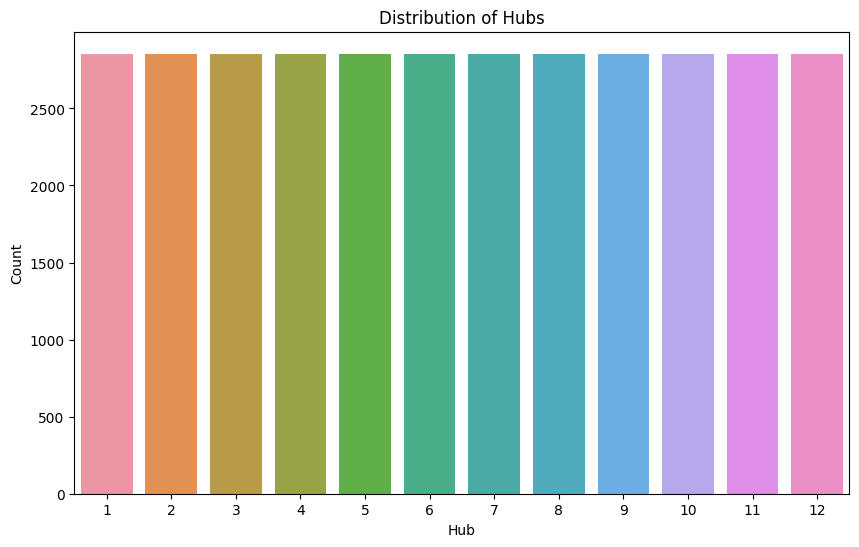

In [253]:
print(list(df['hub'].unique())) # unique hub values. In total there're 12

# Visualization using seaborn. All hubs are equally represented
plt.figure(figsize=(10,6))
sns.countplot(x='hub', data=dfpd)
plt.title('Distribution of Hubs')
plt.xlabel('Hub')
plt.ylabel('Count')
plt.show()

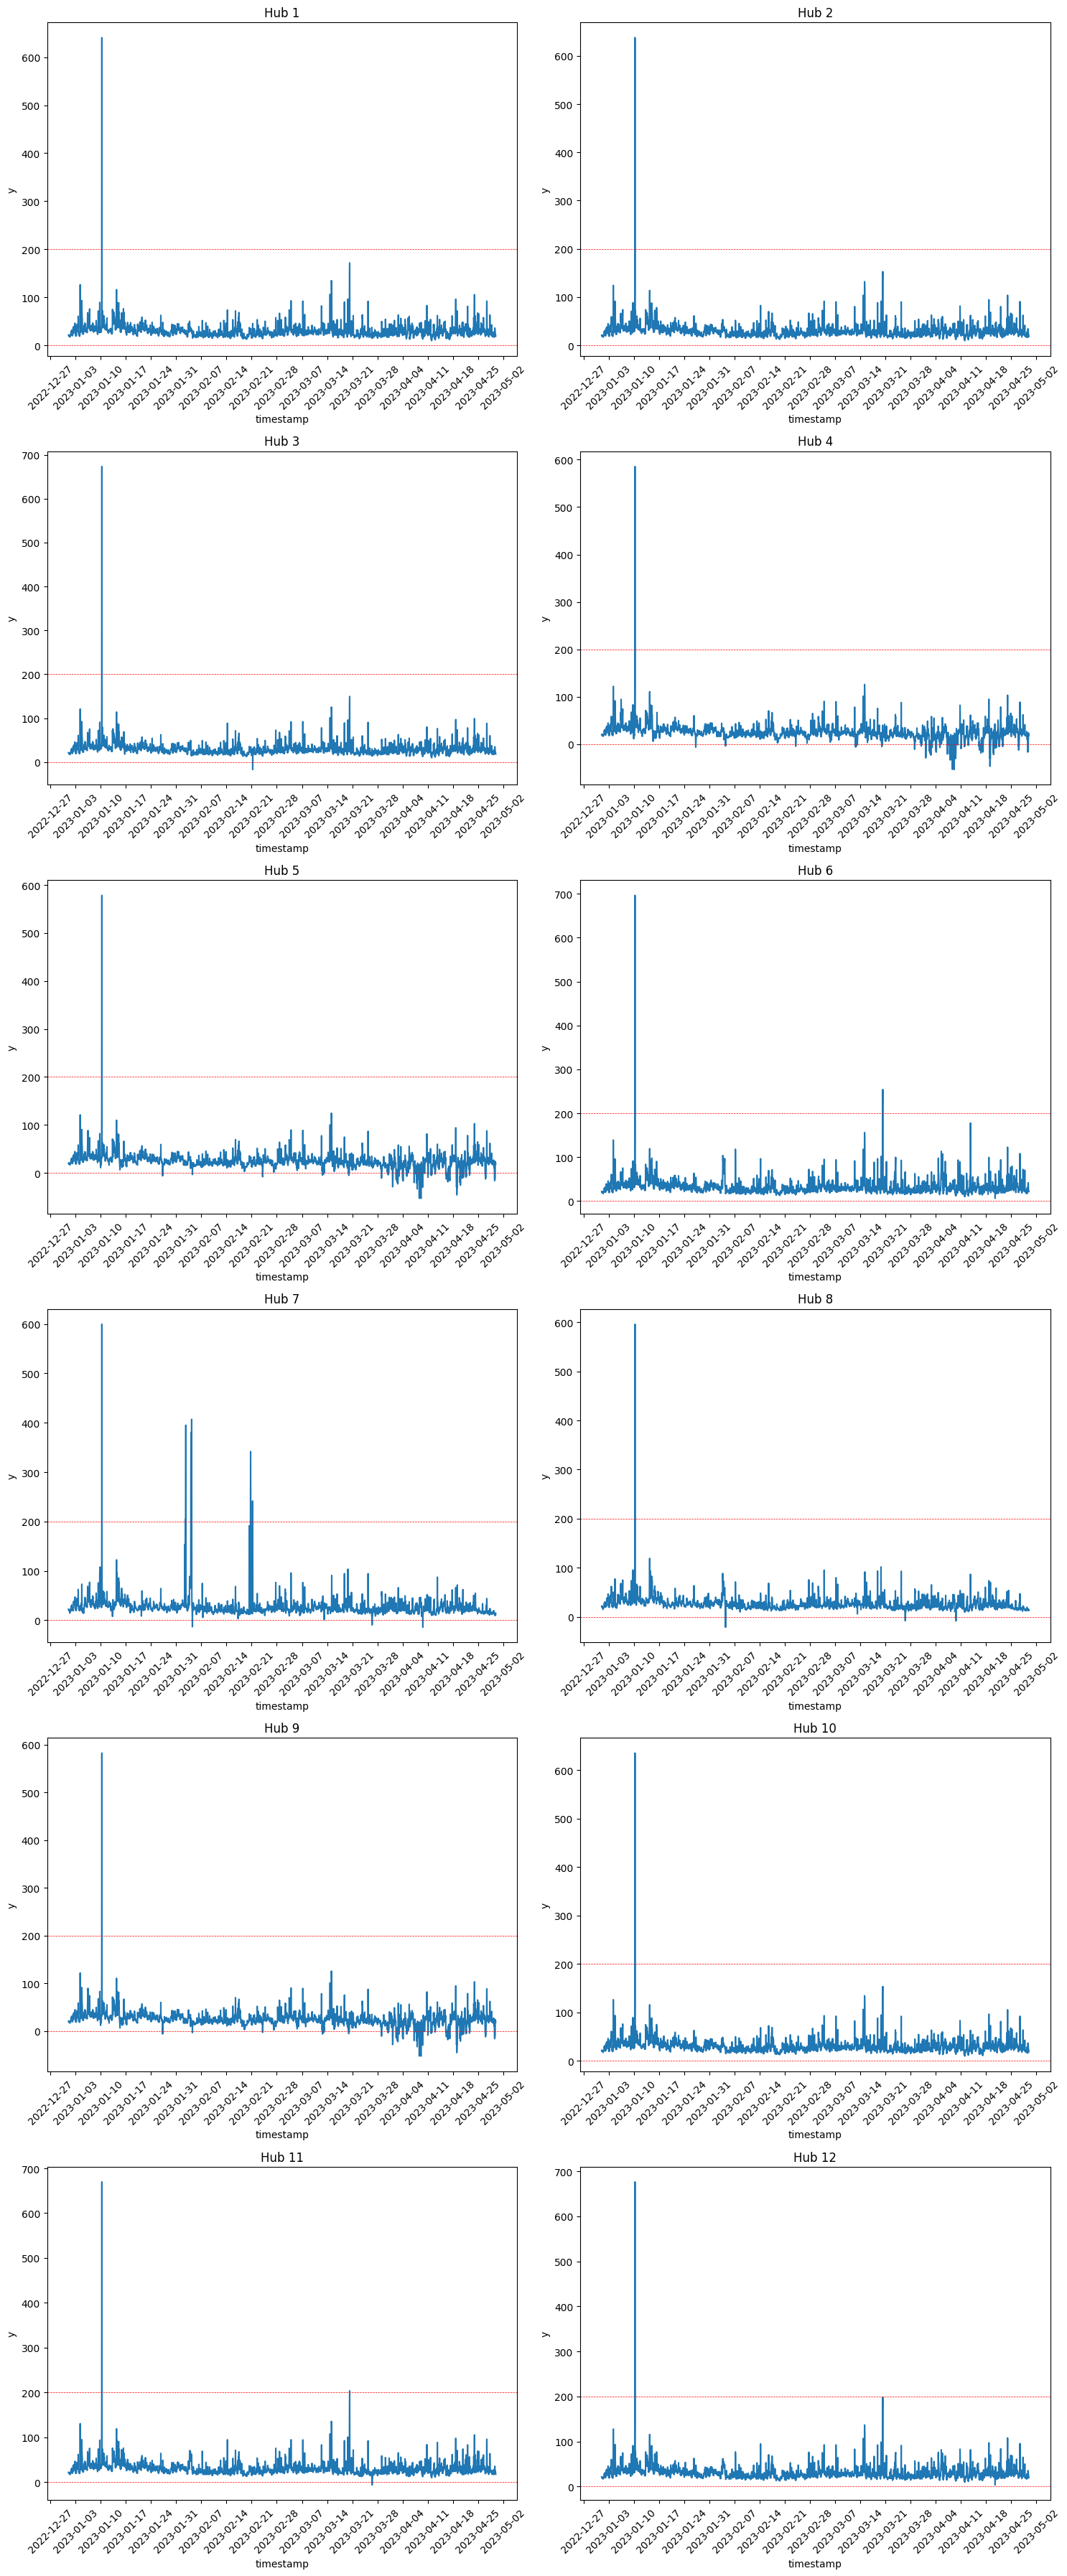

In [254]:
# Get the number of unique hubs
num_hubs = dfpd['hub'].nunique()

# Create a grid of subplots with 6 rows and 2 columns
fig, axs = plt.subplots(6, 2, figsize=(15, num_hubs*3))
axs = axs.ravel() # this will flatten the array of axes for easier indexing

# Iterate over each hub and plot its data on a separate subplot
for i, hub in enumerate(dfpd['hub'].cat.categories):
    # Subset the data to the current hub
    hub_data = dfpd[dfpd['hub'] == hub]
    
    # Plot the data on the subplot
    sns.lineplot(x='timestamp', y='y', data=hub_data, ax=axs[i])
    axs[i].set_title(f'Hub {hub}')

    # Add a horizontal line at y=0
    axs[i].axhline(0, color='red', linewidth=0.5, linestyle='--')

    # Add a horizontal line at y=0
    axs[i].axhline(200, color='red', linewidth=0.5, linestyle='--')
    # Rotate x-axis labels
    plt.setp(axs[i].xaxis.get_majorticklabels(), rotation=45)

    # Display one timestamp per week
    axs[i].xaxis.set_major_locator(mdates.WeekdayLocator())

    # Format x-axis labels as 'YYYY-MM-DD'
    axs[i].xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))

# Automatically adjust the subplot layout for better spacing
plt.tight_layout()

# Show the plot
plt.show()

Hubs are equally represented in the dataset. However, there're an extreme outlier in 10.01.2023 07:00 and for hub 7 there were also outliers in February. We can't visualize the same way all X predictors, as we visualized our target. So, we decided to use a simple rule for outlier detection called three-sigma rule, which would find outliers over the threshold and change those to medians based on the hub and the month, where this outlier occurred.

In [255]:
def replace_outliers(series):
    """
    This function takes a Pandas Series object and returns a Series with outliers replaced by the median of the original series.
    An outlier is defined as a value that is greater than 3 standard deviations from the mean.
    
    Args:
        series (pd.Series): A Pandas Series object in which to replace outliers.
        
    Returns:
        pd.Series: A new Pandas Series with outliers replaced by the median value of the original Series.
    """
    # calculate the mean and standard deviation of the series
    mean_value = series.mean()
    std_value = series.std()
    
    # calculate the mask for the values that are > 3 standard deviations from the mean
    this_mask = np.abs(series - mean_value) > (std_value * 3)
    
    # calculate the median of the series
    median_value = np.nanmedian(series)

    # replace these outliers with the median value
    series[this_mask] = median_value
    
    return series

# Create a copy of the dataframe for manipulation
dfpd_copy = dfpd.copy()

# Filter for January-March period
dfpd_copy = dfpd_copy[dfpd_copy['timestamp'].dt.month.isin([1, 2, 3])]

# List of columns to apply the function, which include 'y' and columns start with 'X' and a digit (X1, X2, ...)
cols_to_check = ['y']
cols_to_check.extend([col for col in dfpd.columns if col.startswith('X') and col[1:].isdigit()])

# Apply the function to each group of ('hub', 'month') and each column in cols_to_check
for col in cols_to_check:
    dfpd_copy[col] = dfpd_copy.groupby(['hub', 'month'])[col].transform(replace_outliers)

# Now, update the original DataFrame with the changes made in the copy
dfpd.update(dfpd_copy)


C:\Users\fs335ld\AppData\Local\Temp\ipykernel_2116\3034162887.py:20: RuntimeWarning: All-NaN slice encountered
  median_value = np.nanmedian(series)


Upper outliers are removed but we kept values below 0 for the reason that they also are heavily represented in the test set (April). It could look like data leakage, as we made our decision based on the test set visualization, but it could be treated as an external market knowledge -> we could know that the prices below 0 appear in the datasets once in a while. In addition, for the below plots we added weekly rolling means which remove the noise of the raw prices and show us a slow downtrend from January.

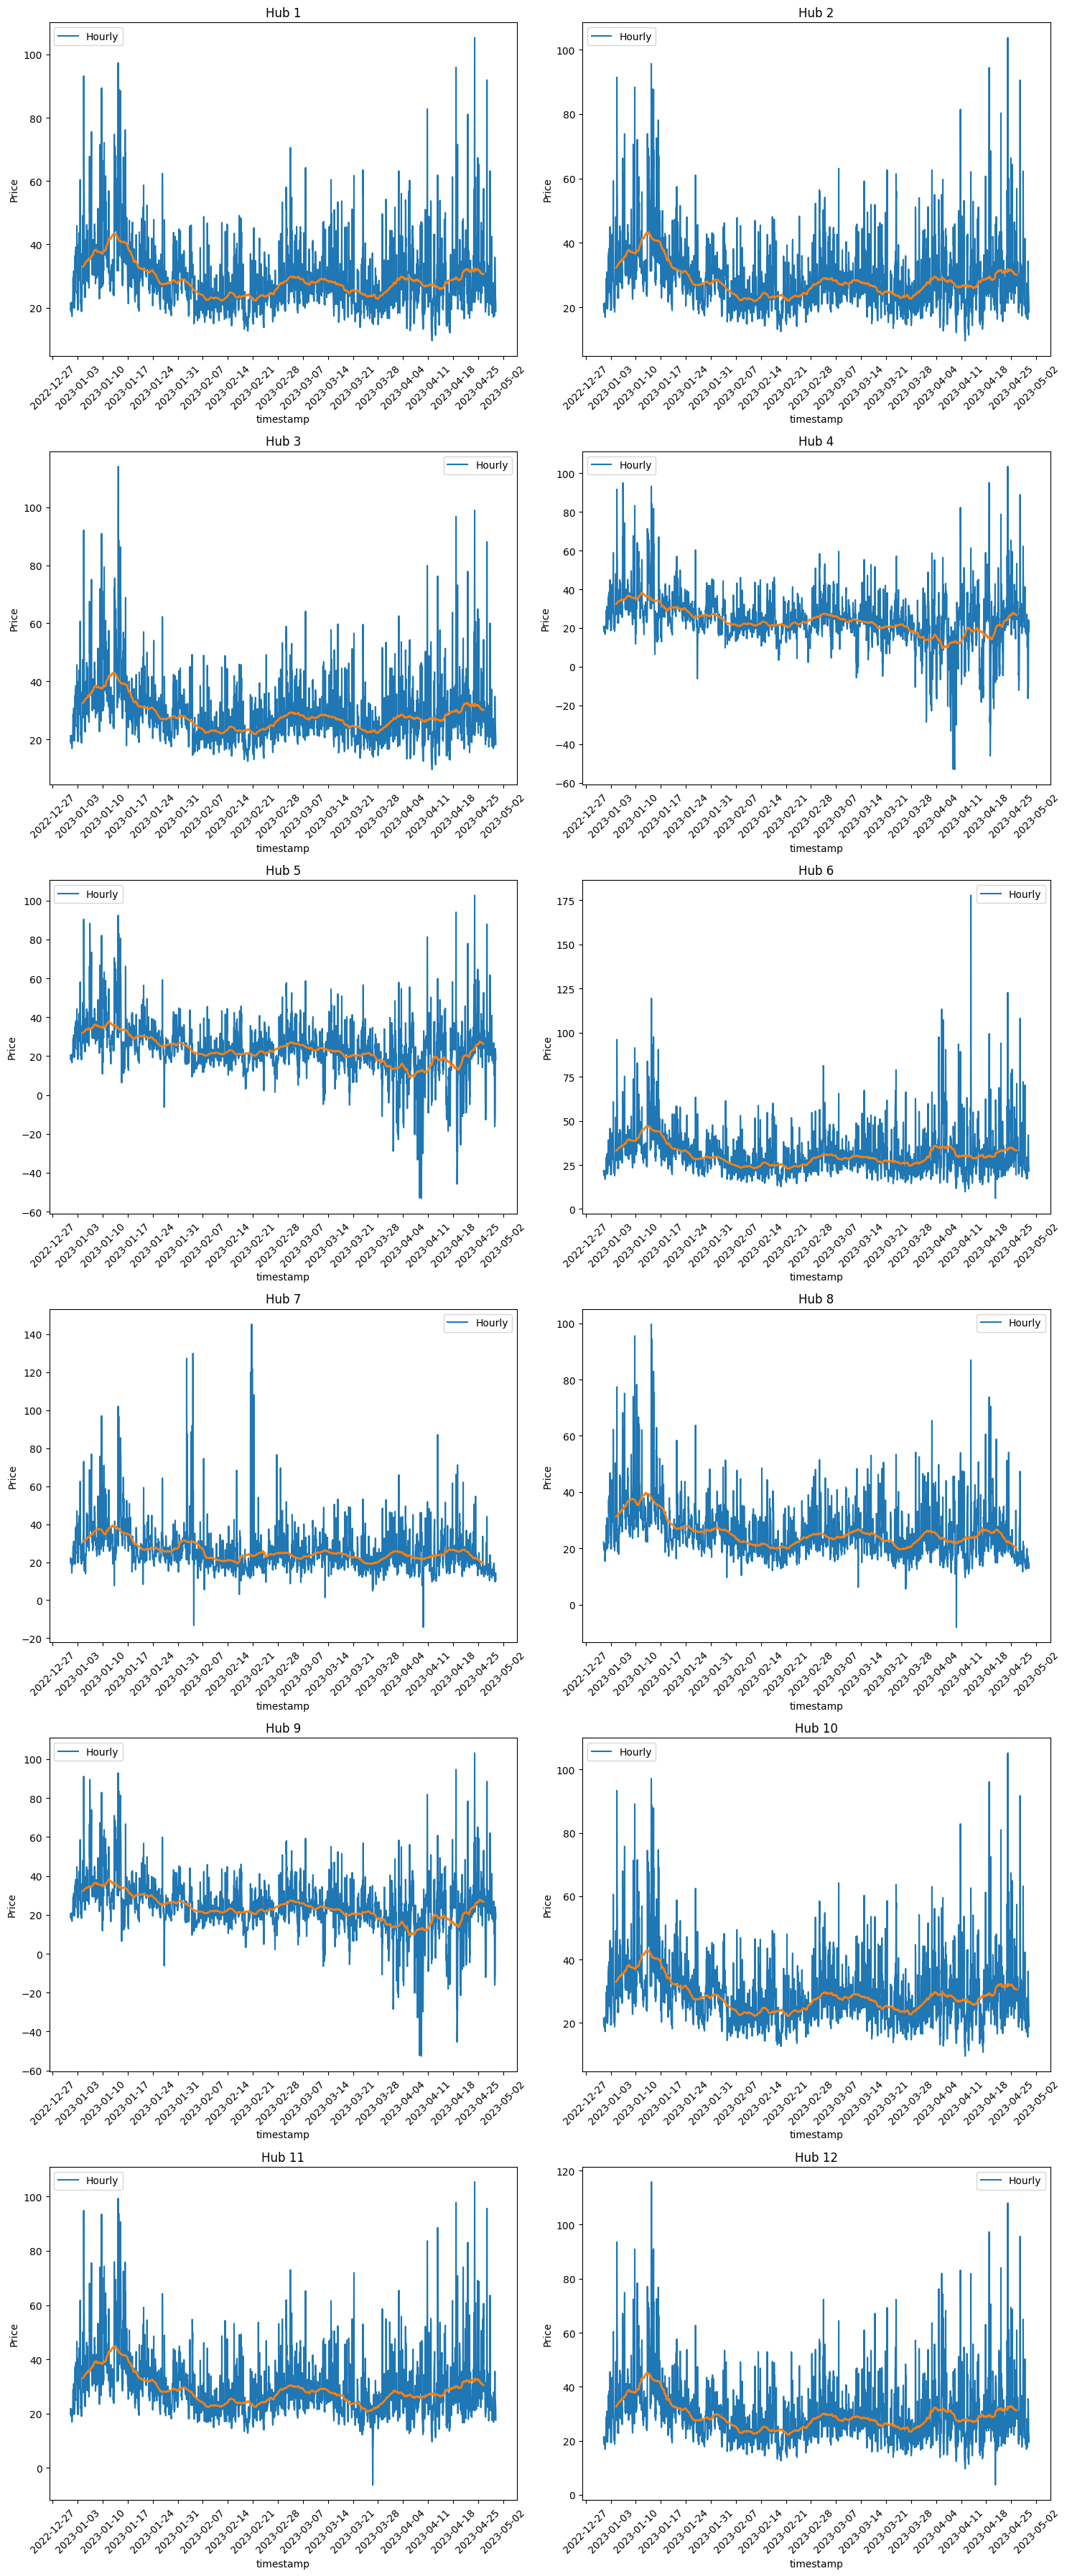

In [256]:
# Plot the hourly actual electricity price, along with the weekly rolling mean

# Create a grid of subplots with 6 rows and 2 columns
fig, axs = plt.subplots(6, 2, figsize=(15, num_hubs*3))
axs = axs.ravel() # this will flatten the array of axes for easier indexing

# Iterate over each hub and plot its data on a separate subplot
for i, hub in enumerate(dfpd['hub'].cat.categories):
    # Subset the data to the current hub
    hub_data = dfpd[dfpd['hub'] == hub]
    
    # Calculate the weekly rolling mean
    rolling = hub_data['y'].rolling(window=24*7, center=True).mean()
    
    # Plot the original data
    sns.lineplot(x='timestamp', y='y', data=hub_data, ax=axs[i], label='Hourly')

    # Plot the weekly rolling mean
    axs[i].plot(hub_data['timestamp'], rolling, linestyle='-', linewidth=2, label='Weekly rolling mean')
    axs[i].set_title(f'Hub {hub}')
    axs[i].set_ylabel('Price')

    # Rotate x-axis labels
    plt.setp(axs[i].xaxis.get_majorticklabels(), rotation=45)

    # Display one timestamp per week
    axs[i].xaxis.set_major_locator(mdates.WeekdayLocator())

    # Format x-axis labels as 'YYYY-MM-DD'
    axs[i].xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))

# Automatically adjust the subplot layout for better spacing
plt.tight_layout()

# Show the plot
plt.show()


The below illustration displays the real-time hourly electricity rates from 00:00 on 05/03/2023 to 23:00 on 19/03/2023, spanning a period of two weeks. A number of discernible patterns and cycles are evident:

The electricity rates fluctuate on a weekly cycle, where prices are generally steeper on weekdays compared to weekends.
There is also an intraday pattern where daytime prices are higher than nighttime rates. Later on, we will make sure that we will generate features which contain these kinds of information.

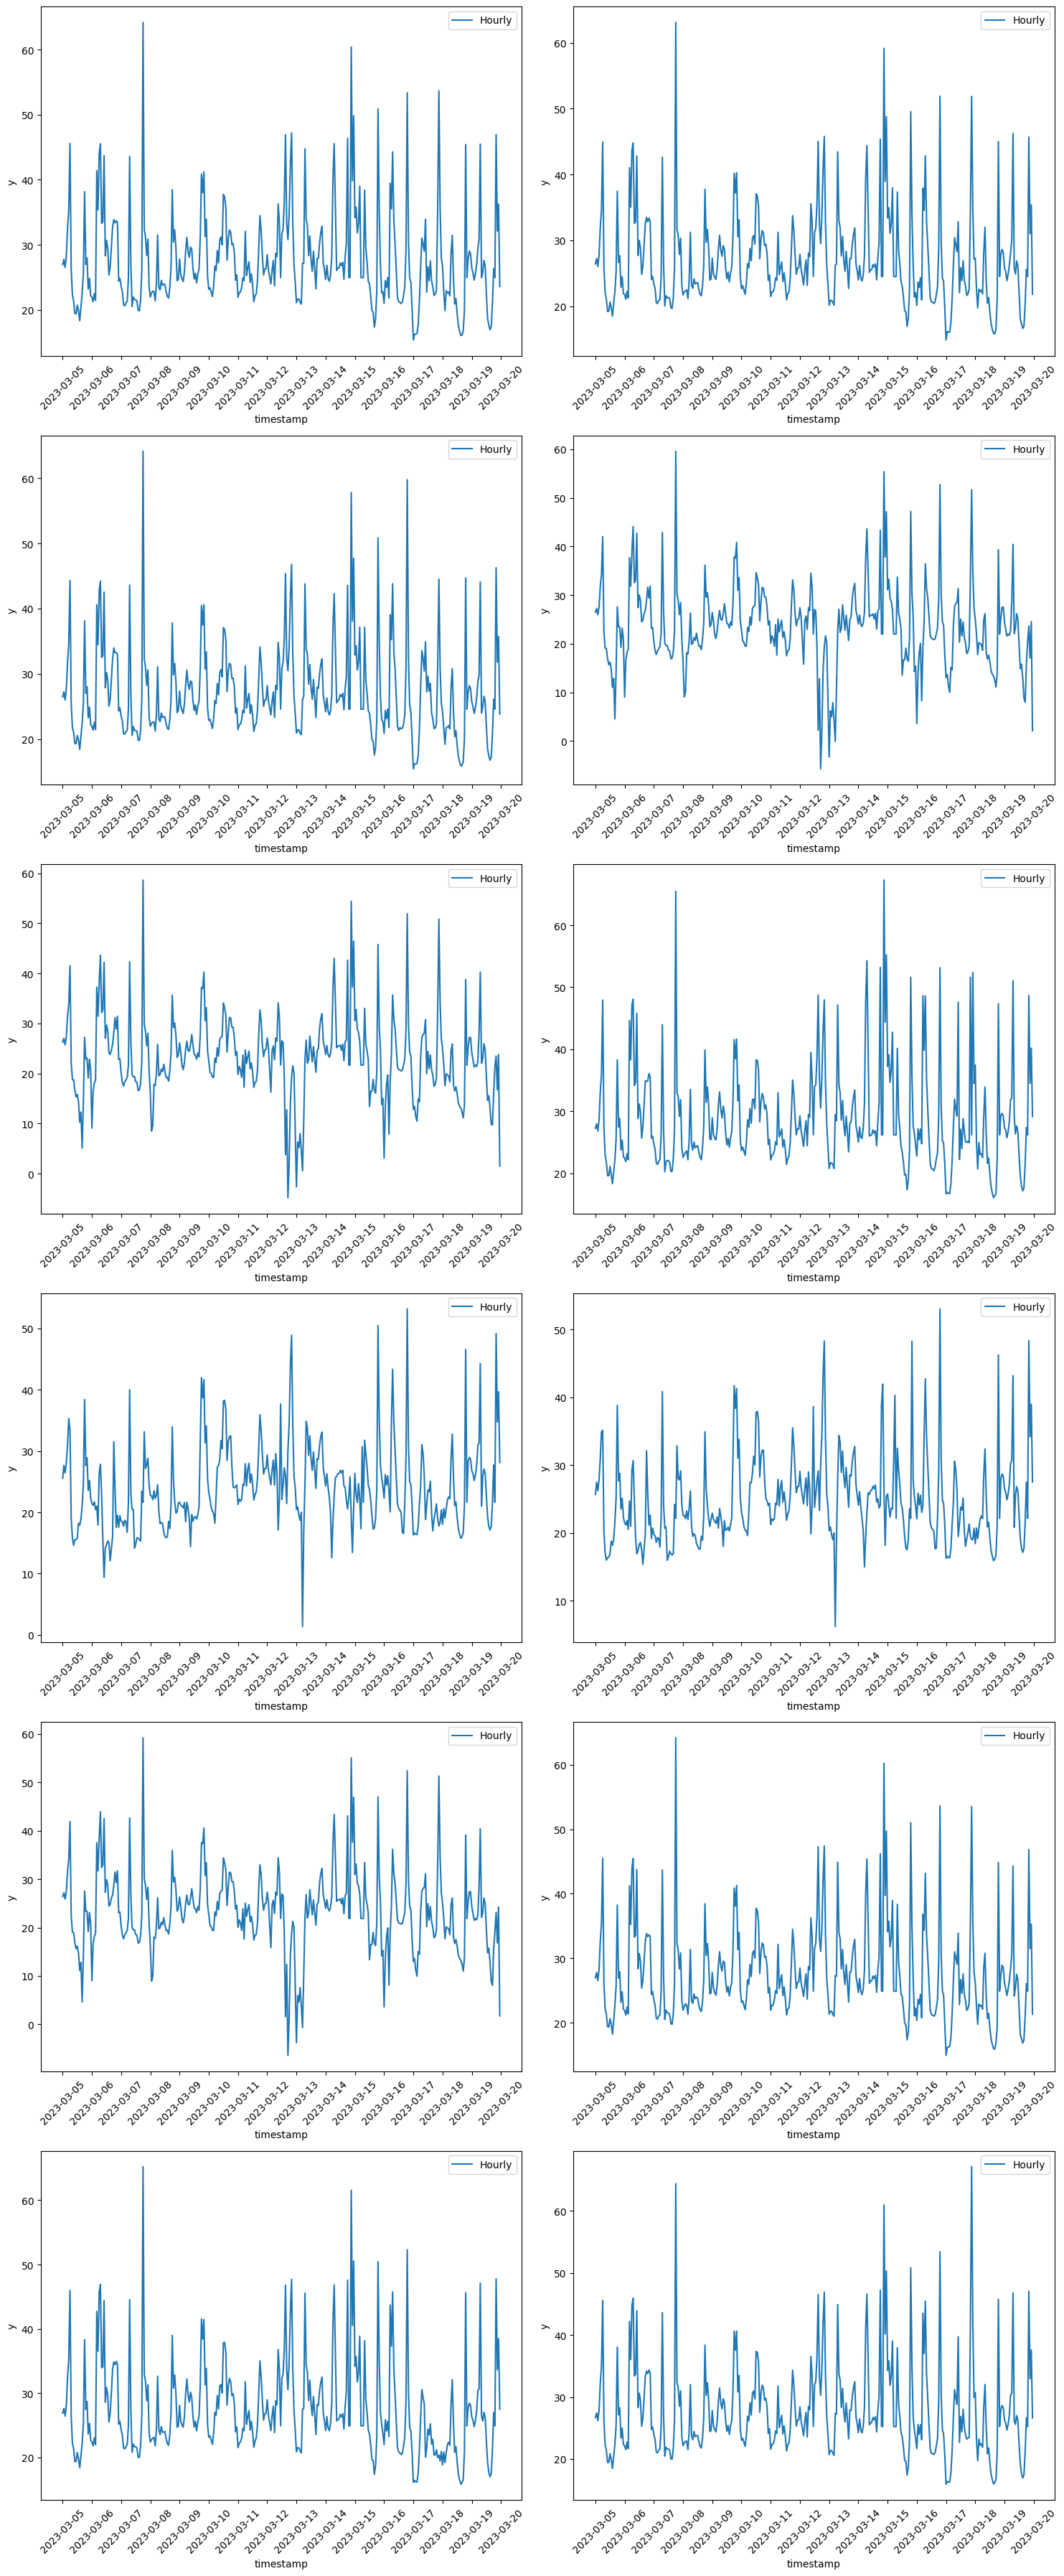

In [257]:
# Create a grid of subplots with 6 rows and 2 columns
fig, axs = plt.subplots(6, 2, figsize=(15, num_hubs*3))
axs = axs.ravel()  # this will flatten the array of axes for easier indexing

# Iterate over each hub and plot its data on a separate subplot
for i, hub in enumerate(dfpd['hub'].cat.categories):
    # Subset the data to the current hub and date range
    hub_data = dfpd[(dfpd['hub'] == hub) &
                    (dfpd['timestamp'].dt.month == 3) &
                    (dfpd['timestamp'].dt.day >= 5) &
                    (dfpd['timestamp'].dt.day <= 19)]
    
    # Plot the original data
    sns.lineplot(x='timestamp', y='y', data=hub_data, ax=axs[i], label='Hourly')

    # Rotate x-axis labels
    plt.setp(axs[i].xaxis.get_majorticklabels(), rotation=45)

    # Display one timestamp per day
    axs[i].xaxis.set_major_locator(mdates.DayLocator())

    # Format x-axis labels as 'YYYY-MM-DD'
    axs[i].xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))

# Automatically adjust the subplot layout for better spacing
plt.tight_layout()

# Show the plot
plt.show()


Prices are right-skewed and could be normalized with log-transformation, but as we have values under 0, it won't work. Fortunately, tree-based algorithms can handle non-normal distributions well.
Let's also quickly check for stationarity, even though it's not a must-have prerequisite for ML models as it's for e.g. ARMA models.Still, if there were unit root, we could also create a feature representing a trend or a drift.

The Augmented Dickey-Fuller (ADF) test, a type of unit root test, determines how strongly a time series is defined by a trend. Its hypotheses are the following:

Null Hypothesis  H0
 : There is a unit root in the time series and thus, is not stationary.
 
Alternative Hypothesis  H1
 : The time series has no unit root and is either stationary or can be made stationary using differencing.

 Based on the outputs of the cell below we can confirm that prices for different hubs don't have unit root, so don't go further with statistical testing. 

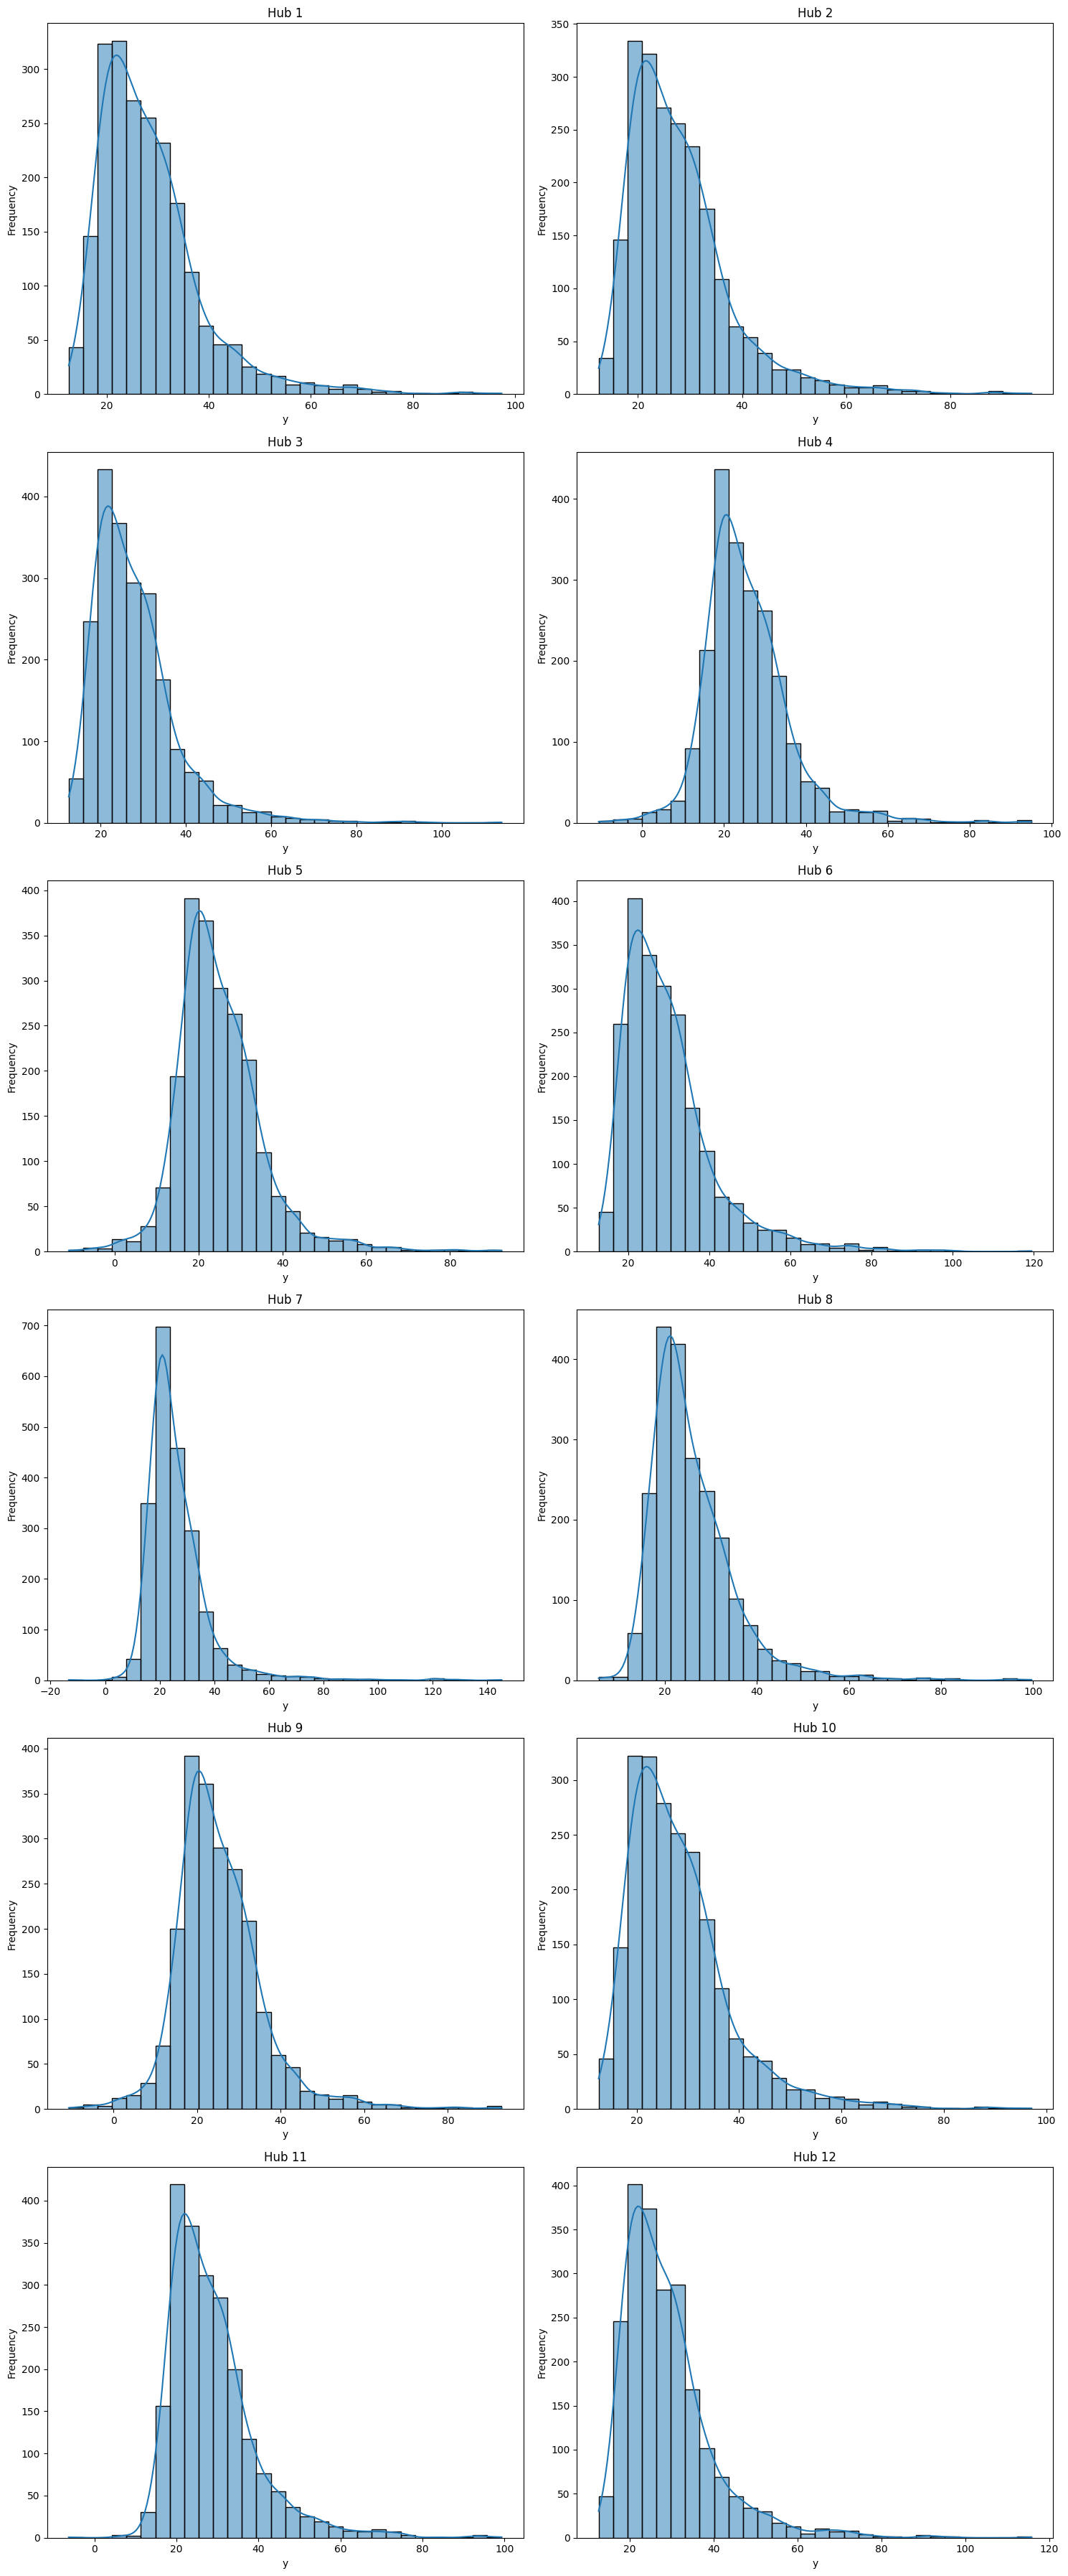

In [258]:
# Filter the data for the period from the 1st of January to the 31st of March
df_subset = dfpd[(dfpd['timestamp'].dt.month.isin([1, 2, 3]))]

# Create a grid of subplots with 6 rows and 2 columns
fig, axs = plt.subplots(6, 2, figsize=(15, df_subset['hub'].nunique()*3))
axs = axs.ravel()  # this will flatten the array of axes for easier indexing

# Iterate over each hub
for i, hub in enumerate(df_subset['hub'].unique()):
    # Filter the data for the current hub
    df_hub = df_subset[df_subset['hub'] == hub]
    
    # Plot a histogram of 'y' for the current hub
    sns.histplot(df_hub['y'], bins=30, ax=axs[i], kde=True)
    axs[i].set_title(f'Hub {hub}')
    axs[i].set_xlabel('y')
    axs[i].set_ylabel('Frequency')

# Automatically adjust the subplot layout for better spacing
plt.tight_layout()

# Show the plot
plt.show()


In [259]:
# Iterate over each unique hub
for hub in dfpd['hub'].unique():
    # Filter the data for the current hub
    df_hub = dfpd[dfpd['hub'] == hub]
    
    y = df_hub['y']
    adf_test = adfuller(y, regression='ct') # constant with trend
    
    print(f'\nHub {hub}')
    print('ADF Statistic: {:.6f}\np-value: {:.6f}\n#Lags used: {}'
          .format(adf_test[0], adf_test[1], adf_test[2]))
    
    for key, value in adf_test[4].items():
        print('Critical Value ({}): {:.6f}'.format(key, value))



Hub 1
ADF Statistic: -5.378527
p-value: 0.000040
#Lags used: 27
Critical Value (1%): -3.961976
Critical Value (5%): -3.412044
Critical Value (10%): -3.127965

Hub 2
ADF Statistic: -5.258018
p-value: 0.000068
#Lags used: 27
Critical Value (1%): -3.961976
Critical Value (5%): -3.412044
Critical Value (10%): -3.127965

Hub 3
ADF Statistic: -5.312300
p-value: 0.000054
#Lags used: 27
Critical Value (1%): -3.961976
Critical Value (5%): -3.412044
Critical Value (10%): -3.127965

Hub 4
ADF Statistic: -7.522336
p-value: 0.000000
#Lags used: 27
Critical Value (1%): -3.961976
Critical Value (5%): -3.412044
Critical Value (10%): -3.127965

Hub 5
ADF Statistic: -7.521928
p-value: 0.000000
#Lags used: 27
Critical Value (1%): -3.961976
Critical Value (5%): -3.412044
Critical Value (10%): -3.127965

Hub 6
ADF Statistic: -5.498872
p-value: 0.000023
#Lags used: 27
Critical Value (1%): -3.961976
Critical Value (5%): -3.412044
Critical Value (10%): -3.127965

Hub 7
ADF Statistic: -6.512649
p-value: 0.000

Let's also plot ACF and PACF plots of our prices per hub. Blue area is the confidence region (rejection region). Based on ACF, we have very strong memory of time-series. However, the direct relationship between an observation at a given hour (t) is strongest with the observations at t-1 time-step and diminishes afterwards based on PACF. There're significant partial autocorrelations at times t-9, t-10 and t-23,t-24 (previous day). This information will be accommodated in the feature engineering phase.

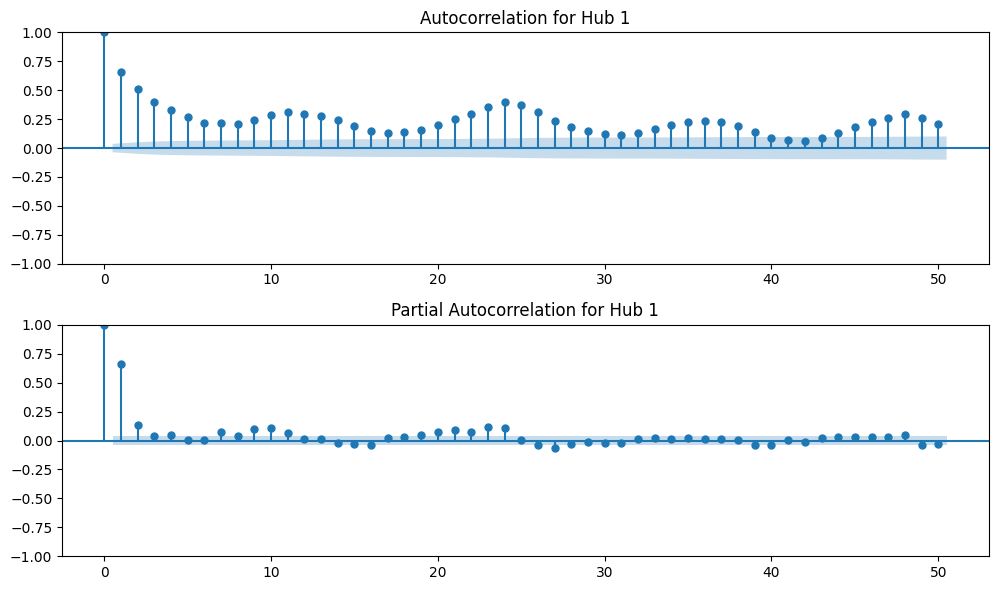

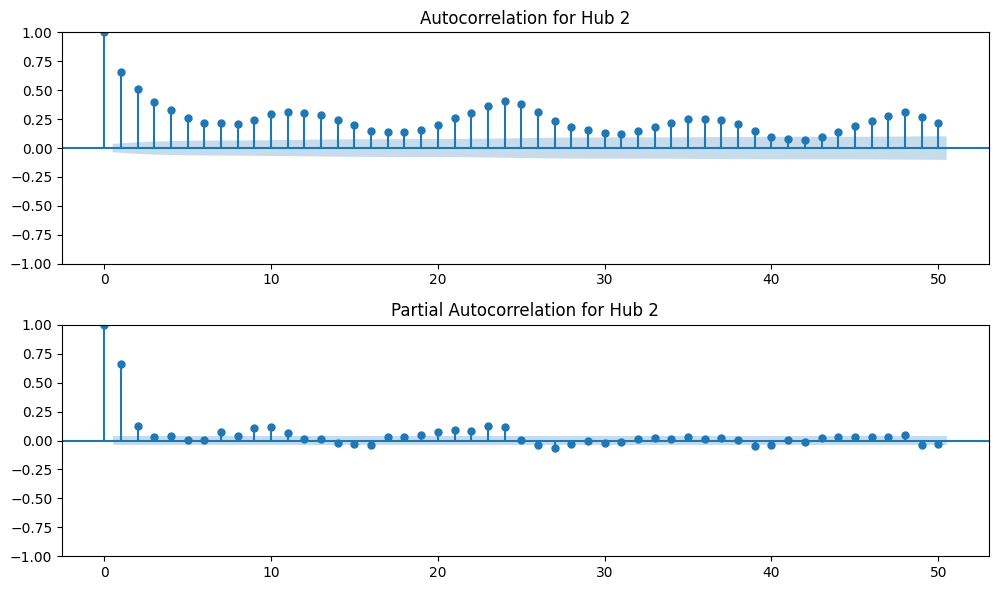

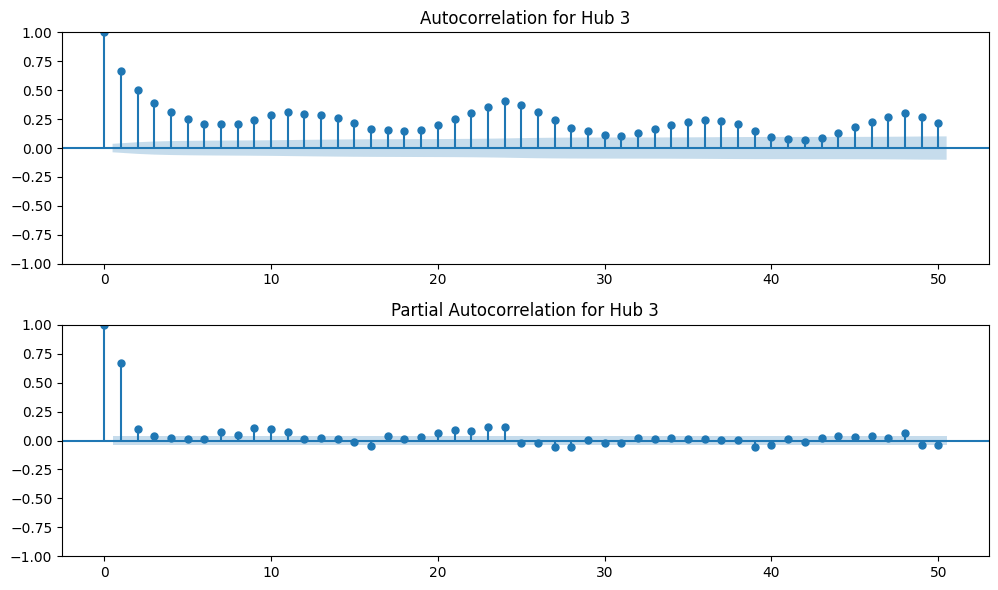

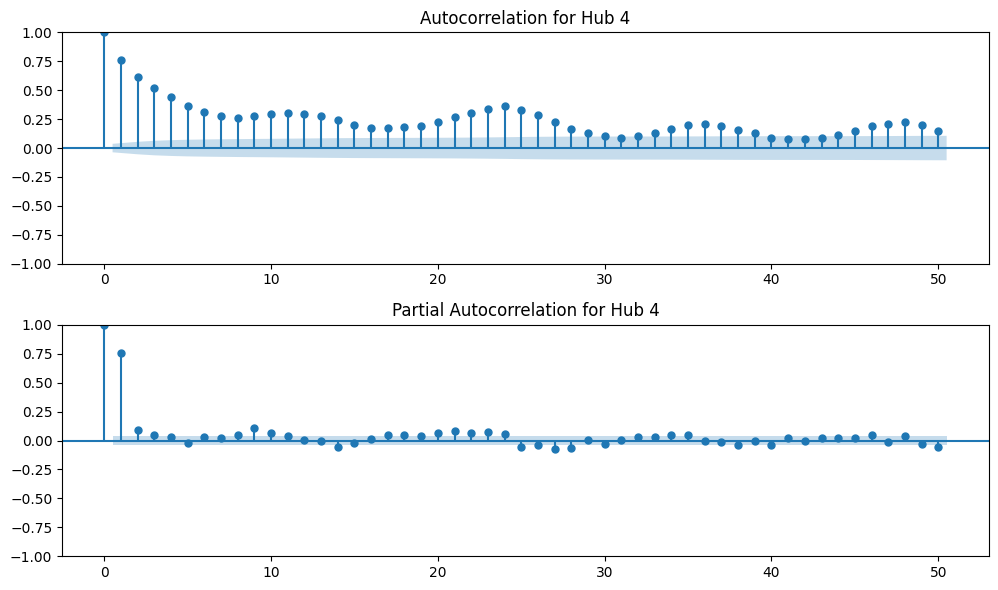

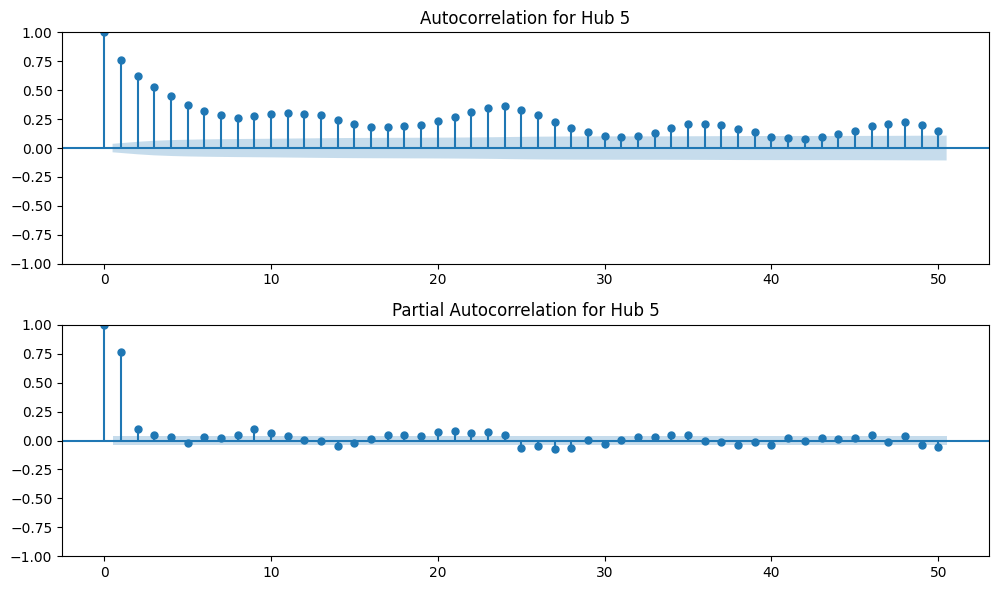

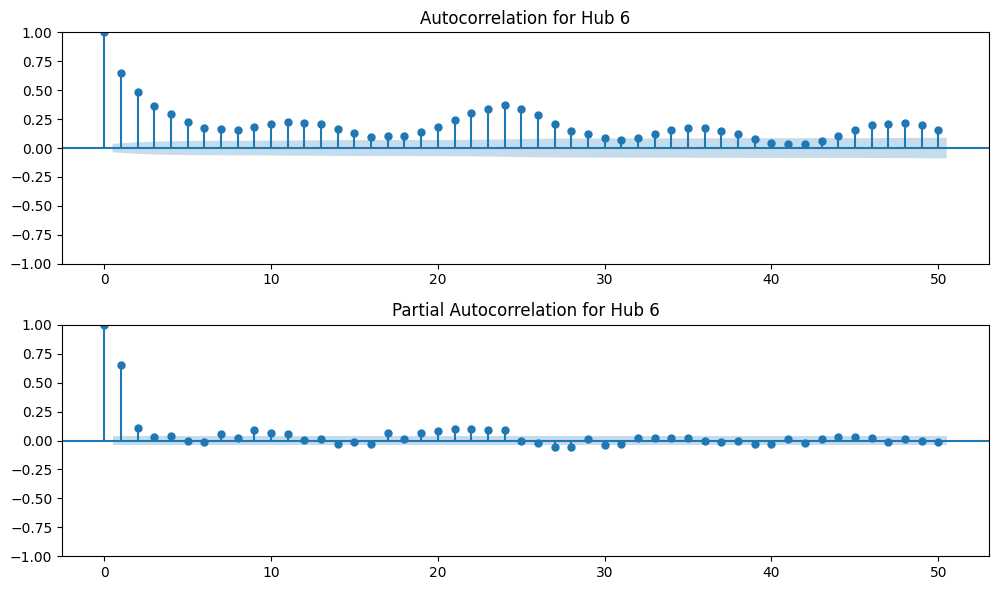

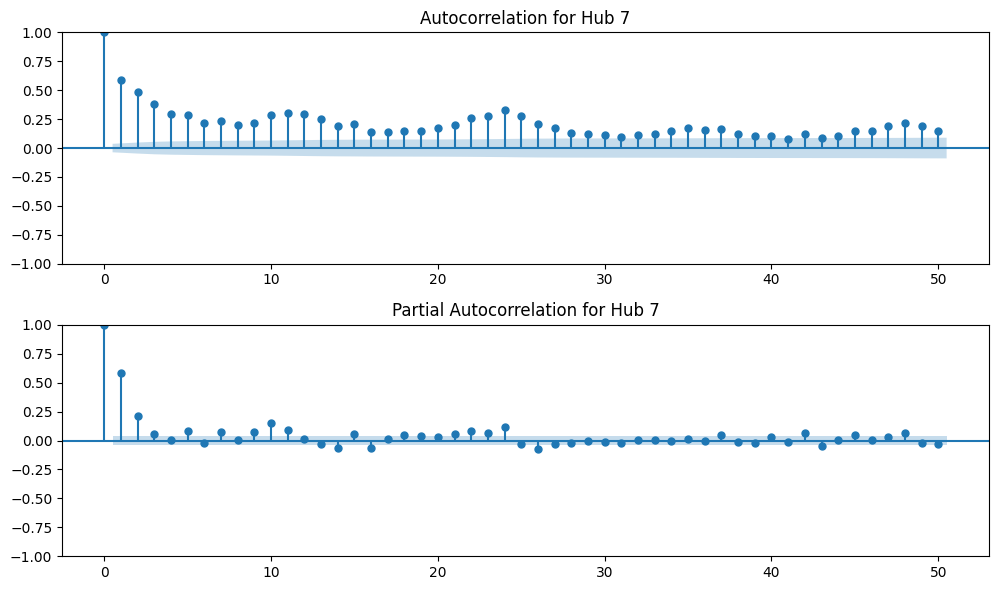

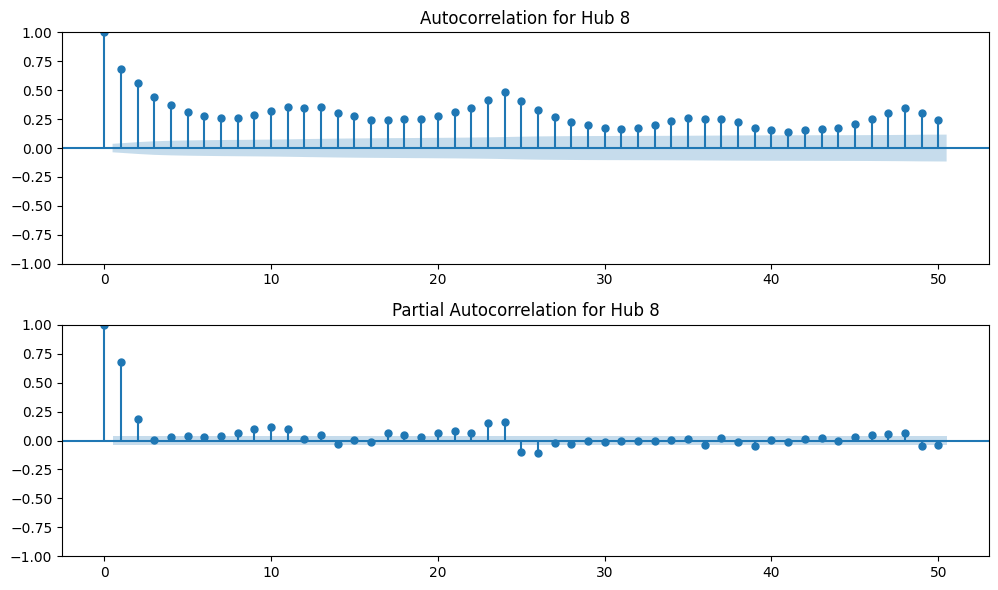

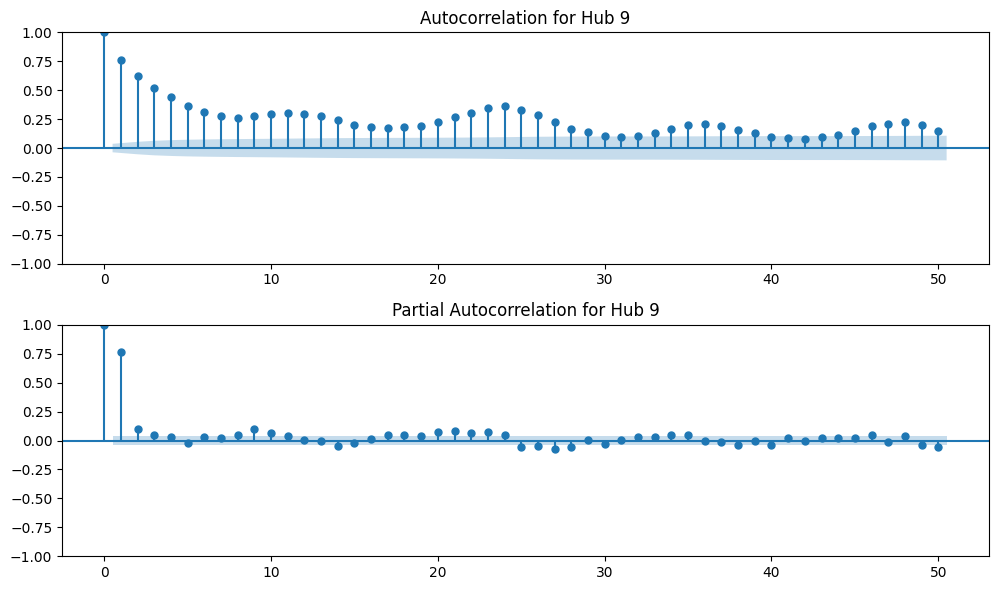

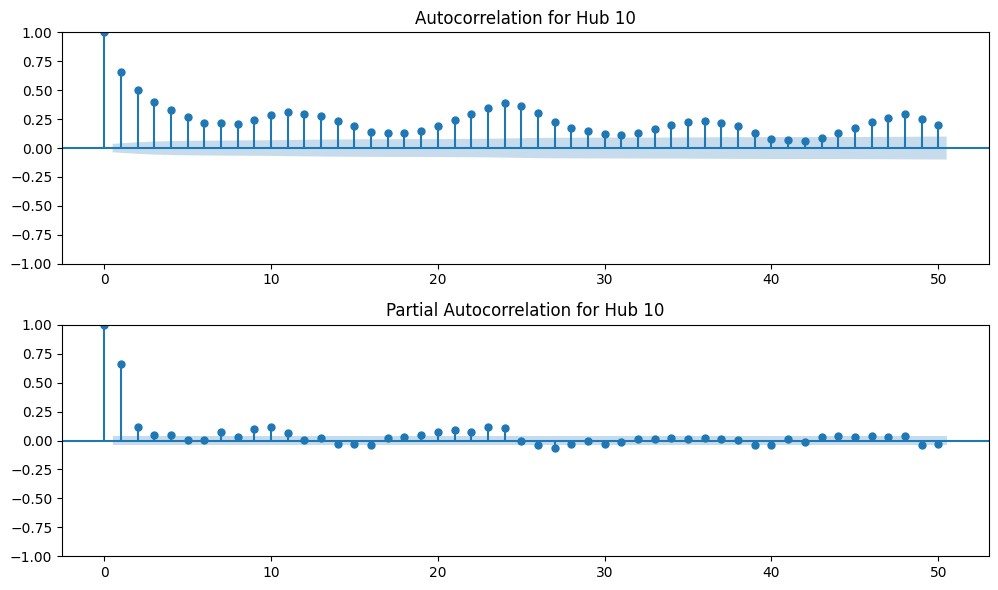

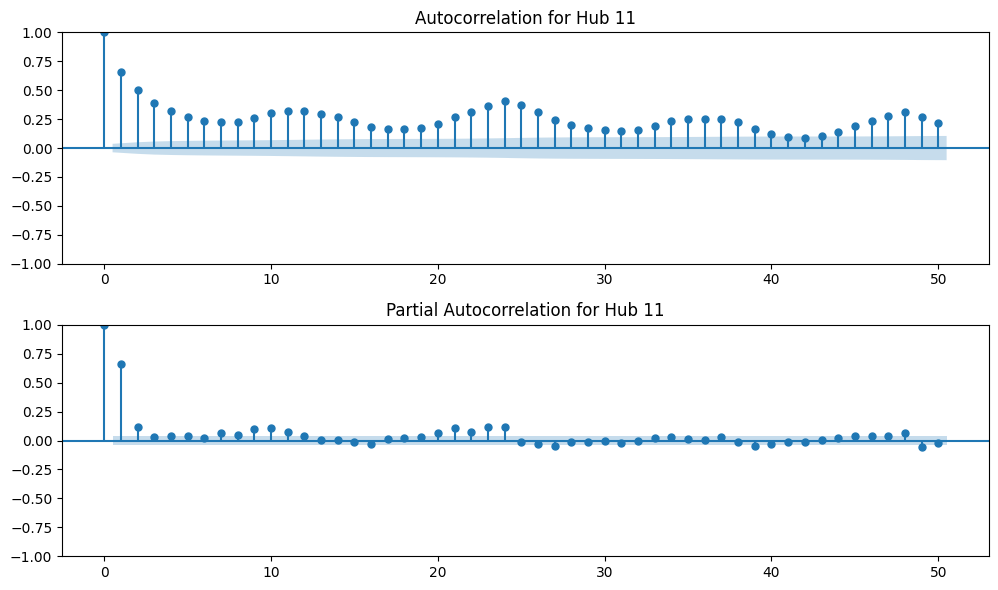

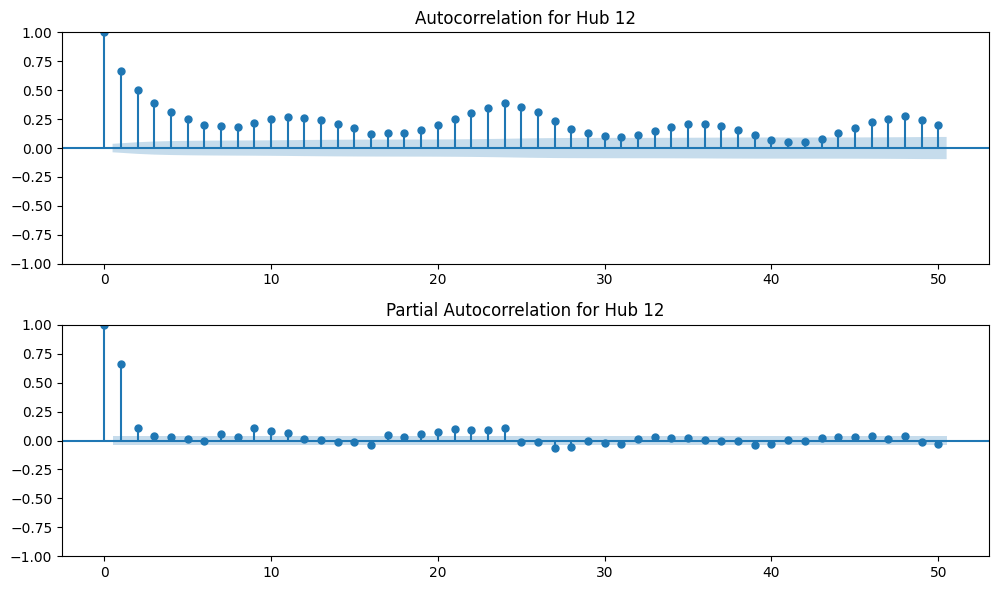

In [260]:
# Iterate over each unique hub
for hub in dfpd['hub'].unique():
    # Filter the data for the current hub
    df_hub = dfpd[dfpd['hub'] == hub]
    
    y = df_hub['y']
    
    fig, (ax1, ax2) = plt.subplots(nrows=2, figsize=(10, 6))
    
    # Create autocorrelation and partial autocorrelation plots
    plot_acf(y, lags=50, ax=ax1, alpha=0.05)
    plot_pacf(y, lags=50, ax=ax2, alpha=0.05)
    
    # Set the title for the plots
    ax1.set_title(f'Autocorrelation for Hub {hub}')
    ax2.set_title(f'Partial Autocorrelation for Hub {hub}')

    # Adjust the layout
    plt.tight_layout()
    plt.show()


# 3. Missing Values Handling
In this chapter, we are visualizing and trying to understand the behaviour and patterns of missing observations, and the way how to overcome NAs in the dataset.

All the missing values come from X1-X798 columns. There's a huge difference in the missing ratios. Some X have more than 0.5 of values missing and some have only minor cases.

1. Columns with the critical number of missing values will be grouped against hubs to understand if there're hubs where no values are missing. Then, these critical columns will be grouped against hours to see if there are time patterns involved. 
2. Columns with minor missing cases will be examined to find missing patterns. If possible, these missing values will be linearly interpolated.


X112    25695
X636    18576
X55     18576
X67     18576
X755    18576
        ...  
X234      288
X658      288
X576      276
X4        276
X689      276
Length: 344, dtype: int64


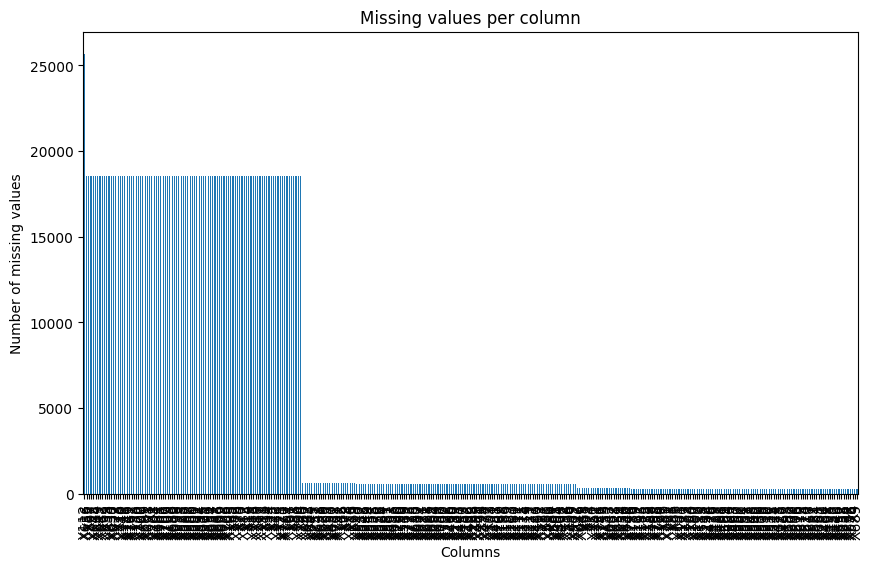

X112    0.750000
X630    0.542207
X636    0.542207
X70     0.542207
X758    0.542207
          ...   
X80     0.008406
X104    0.008406
X576    0.008056
X4      0.008056
X689    0.008056
Length: 344, dtype: float64


In [261]:
# Calculate missing values
missing_values = dfpd.isna().sum()

# Filter out columns where missing_values is 0
missing_values = missing_values[missing_values > 0].sort_values(ascending=False)

if len(missing_values) > 0:

    # a) Missing values sorted in descending order
    print(missing_values)

    # b) Bar chart of missing values from biggest to smallest
    plt.figure(figsize=(10,6))
    missing_values.plot(kind='bar')
    plt.title('Missing values per column')
    plt.xlabel('Columns')
    plt.ylabel('Number of missing values')
    plt.show()

    # c) Ratio of missing values per column over all values in a dataset
    missing_ratio = (missing_values / len(dfpd)).sort_values(ascending=False)
    print(missing_ratio)
else:
    print("There are no missing values in the dataset.")


<Axes: >

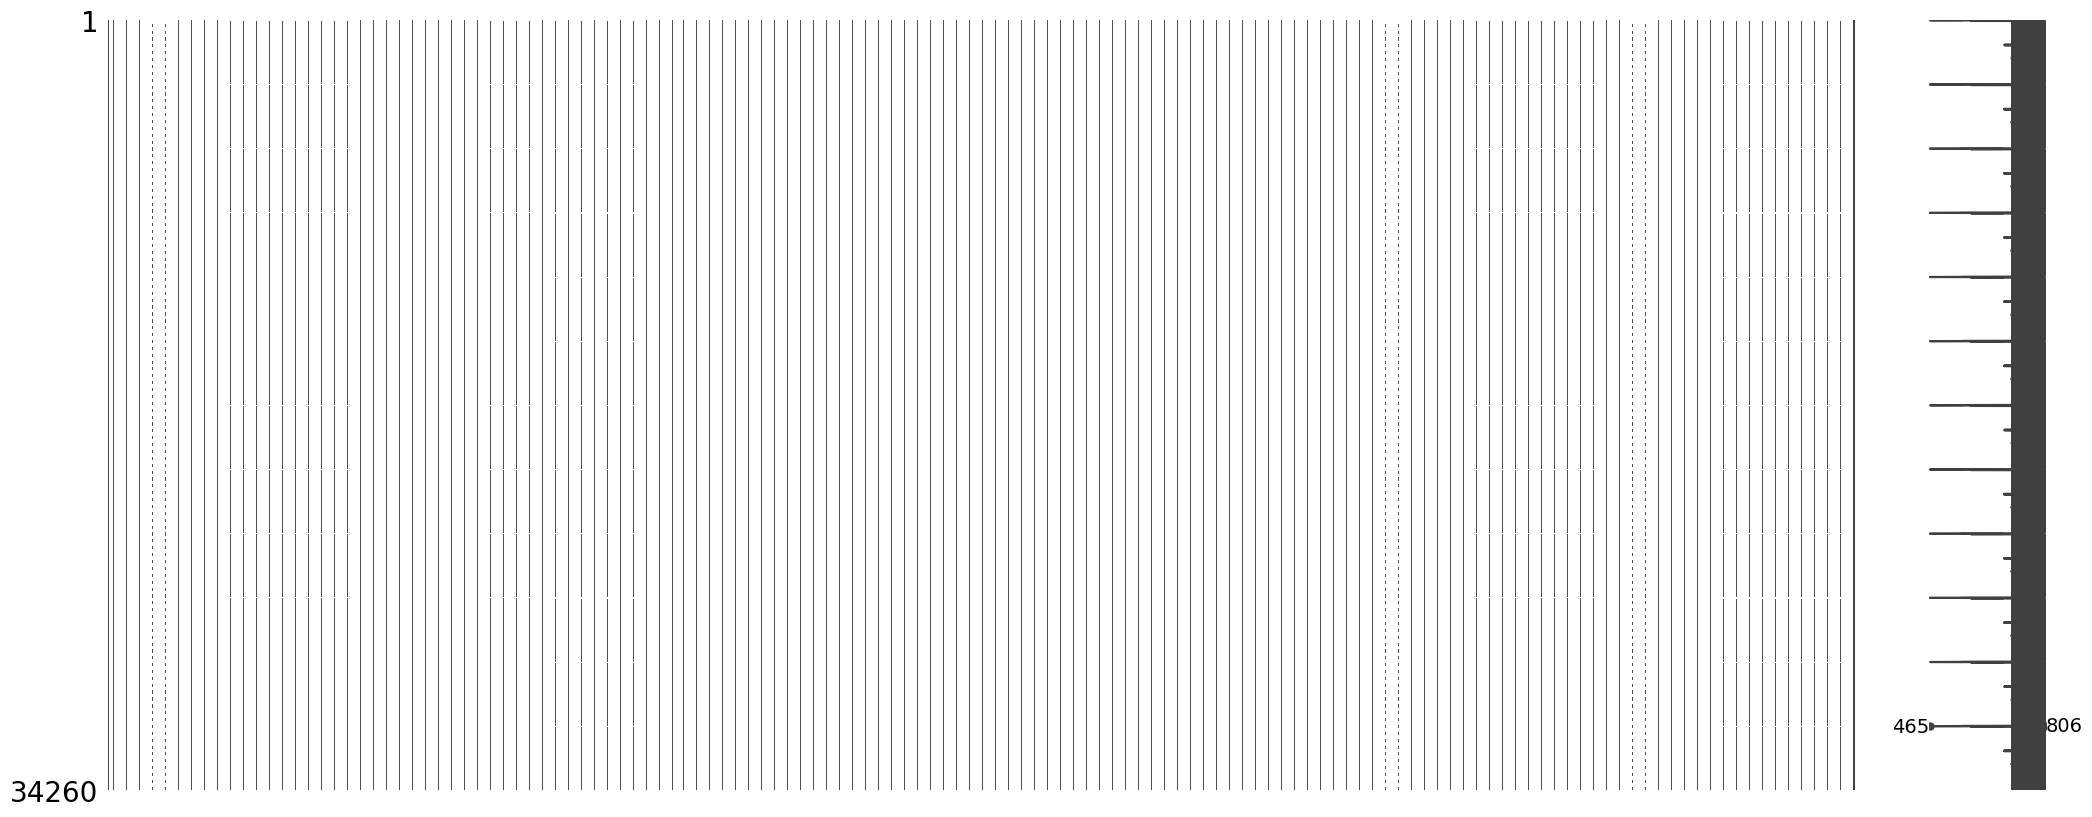

In [262]:
# Visualize missing values as a matrix
msno.matrix(dfpd)

Looks like the missing values with extreme number of cases for several columns are missing under some specific pattern. After grouping dataset by hubs, we found out that column X112 has missing values only for several specific hubs. Other columns are uniformly missing.

In [263]:
# Identify columns with more than 0.3 missing values. Number was taking arbitrarily. It could be 0.5 with the same effect.
columns_extreme_NA = missing_ratio[missing_ratio > 0.3].index
# Group by 'hub' and calculate missing ratio for each group
missing_ratio_by_hub = dfpd.groupby('hub')[columns_extreme_NA].apply(lambda x : x.isnull().sum() / len(x))

# Print the result
print(missing_ratio_by_hub)

# Initialize an empty list to store columns with non-uniform missing value distribution
cols_with_nonuniform_missing = []

# Check each column
for col in missing_ratio_by_hub.columns:
    # If the range of missing ratios for this column is larger than 0.01...
    if missing_ratio_by_hub[col].max() - missing_ratio_by_hub[col].min() > 0.01:
        # Add this column to the list
        cols_with_nonuniform_missing.append(col)
print('\n')
print(f"Columns with non-uniform missing value distribution across 'hub': {cols_with_nonuniform_missing}")


     X112      X630      X636       X70      X758      X752      X749  \
hub                                                                     
1     0.0  0.542207  0.542207  0.542207  0.542207  0.542207  0.542207   
2     1.0  0.542207  0.542207  0.542207  0.542207  0.542207  0.542207   
3     1.0  0.542207  0.542207  0.542207  0.542207  0.542207  0.542207   
4     1.0  0.542207  0.542207  0.542207  0.542207  0.542207  0.542207   
5     1.0  0.542207  0.542207  0.542207  0.542207  0.542207  0.542207   
6     1.0  0.542207  0.542207  0.542207  0.542207  0.542207  0.542207   
7     0.0  0.542207  0.542207  0.542207  0.542207  0.542207  0.542207   
8     1.0  0.542207  0.542207  0.542207  0.542207  0.542207  0.542207   
9     1.0  0.542207  0.542207  0.542207  0.542207  0.542207  0.542207   
10    1.0  0.542207  0.542207  0.542207  0.542207  0.542207  0.542207   
11    0.0  0.542207  0.542207  0.542207  0.542207  0.542207  0.542207   
12    1.0  0.542207  0.542207  0.542207  0.542207  

As was expected, X112 has the equal ratio of missing values per hour, month and day. Its missingness is based mainly on the hub. All other examined variables with extreme missing cases have missing values starting from 11 till 23. And for the specific predictors, we have missing values during hour 1. Missing values do not depend on the day of the month or the month itself.

Possible solutions:

a. For the 11:00-23:00 period we will fill it in with the average of 10 previous hours. In addition, we will create a binary variable indicating whether the time is in between 11:00 till 23:00 or not. Instead of using mean values we could also use last available value of the day and forward it till 23:00 (take 10:00 and repeat it till 23:00) BUT as we don't have any additional knowledge regarding the nature of these variables, we will be using averages.

b. For missing values in hour 1 we will use linear interpolation from 0:00 taking into consideration different hubs. We use linear as we don't have any explicit knowledge about variables. We will use forward direction. While there may be alternative forms of interpolation that could potentially yield better results, we still opt for utilizing the most straightforward model available. Despite a minor portion of our input data being subject to noise, its impact on performance is expected to be negligible.

c. For the variables with minor cases of missing values, we will first examine the reasons and if applicable, we would also use linear interpolation.

In [264]:
# Filter the dataframe to include only columns in 'columns_extreme_NA'
df_extreme_cols = dfpd[columns_extreme_NA]

# Create a binary mask where 1 represents missing values and 0 otherwise
binary_mask = df_extreme_cols.isna().astype(int)

# Add 'hour' column to the mask
binary_mask['hour'] = dfpd['hour']

# Group by 'hour' and calculate the mean missingness
avg_missingness_by_hour = binary_mask.groupby('hour').mean()

# Print the result
pd.set_option('display.max_columns', None)
display(avg_missingness_by_hour)

print('\n')
# Add 'month' column to the mask
binary_mask['month'] = dfpd['month']

# Group by 'month' and calculate the mean missingness
avg_missingness_by_month = binary_mask.groupby('month').mean()

# Print the result
pd.set_option('display.max_columns', None)
display(avg_missingness_by_month)

print('\n')
# Add 'day' column to the mask
binary_mask['day'] = dfpd['day']

# Group by 'day' and calculate the mean missingness
avg_missingness_by_day = binary_mask.groupby('day').mean()

# Print the result
pd.set_option('display.max_columns', None)
display(avg_missingness_by_day)


X112      X630      X636       X70      X758      X752      X749  \
hour                                                                     
0     0.75  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
1     0.75  0.008403  0.008403  0.008403  0.008403  0.008403  0.008403   
2     0.75  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
3     0.75  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
4     0.75  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
5     0.75  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
6     0.75  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
7     0.75  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
8     0.75  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
9     0.75  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
10    0.75  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
11    0.75  1.000000  1.000000  1.000000  1.000000  1.000000  1.000000   
12    0.75  1.000000  1.000000  1.000000  1.000000  1.000000  1.000000   
13    0.75  1.000000  1.000000  1.000000  1.000000  1.000000  1.000000   
14    0.75  1.000000  1.000000  1.000000  1.000000  1.000000  1.000000   
15    0.75  1.000000  1.000000  1.000000  1.000000  1.000000  1.000000   
16    0.75  1.000000  1.000000  1.000000  1.000000  1.000000  1.000000   
17    0.75  1.000000  1.000000  1.000000  1.000000  1.000000  1.000000   
18    0.75  1.000000  1.000000  1.000000  1.000000  1.000000  1.000000   
19    0.75  1.000000  1.000000  1.000000  1.000000  1.000000  1.000000   
20    0.75  1.000000  1.000000  1.000000  1.000000  1.000000  1.000000   
21    0.75  1.000000  1.000000  1.000000  1.000000  1.000000  1.000000   
22    0.75  1.000000  1.000000  1.000000  1.000000  1.000000  1.000000   
23    0.75  1.000000  1.000000  1.000000  1.000000  1.000000  1.000000   

          X746      X743      X740       X76       X73      X627      X761  \
hour                                                                         
0     0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
1     0.008403  0.008403  0.008403  0.008403  0.008403  0.008403  0.008403   
2     0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
3     0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
4     0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
5     0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
6     0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
7     0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
8     0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
9     0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
10    0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
11    1.000000  1.000000  1.000000  1.000000  1.000000  1.000000  1.000000   
12    1.000000  1.000000  1.000000  1.000000  1.000000  1.000000  1.000000   
13    1.000000  1.000000  1.000000  1.000000  1.000000  1.000000  1.000000   
14    1.000000  1.000000  1.000000  1.000000  1.000000  1.000000  1.000000   
15    1.000000  1.000000  1.000000  1.000000  1.000000  1.000000  1.000000   
16    1.000000  1.000000  1.000000  1.000000  1.000000  1.000000  1.000000   
17    1.000000  1.000000  1.000000  1.000000  1.000000  1.000000  1.000000   
18    1.000000  1.000000  1.000000  1.000000  1.000000  1.000000  1.000000   
19    1.000000  1.000000  1.000000  1.000000  1.000000  1.000000  1.000000   
20    1.000000  1.000000  1.000000  1.000000  1.000000  1.000000  1.000000   
21    1.000000  1.000000  1.000000  1.000000  1.000000  1.000000  1.000000   
22    1.000000  1.000000  1.000000  1.000000  1.000000  1.000000  1.000000   
23    1.000000  1.000000  1.000000  1.000000  1.000000  1.000000  1.000000   

          X633       X64       X58       X55       X

X112      X630      X636       X70      X758      X752      X749  \
month                                                                     
1      0.75  0.541667  0.541667  0.541667  0.541667  0.541667  0.541667   
2      0.75  0.541667  0.541667  0.541667  0.541667  0.541667  0.541667   
3      0.75  0.543742  0.543742  0.543742  0.543742  0.543742  0.543742   
4      0.75  0.541667  0.541667  0.541667  0.541667  0.541667  0.541667   

           X746      X743      X740       X76       X73      X627      X761  \
month                                                                         
1      0.541667  0.541667  0.541667  0.541667  0.541667  0.541667  0.541667   
2      0.541667  0.541667  0.541667  0.541667  0.541667  0.541667  0.541667   
3      0.543742  0.543742  0.543742  0.543742  0.543742  0.543742  0.543742   
4      0.541667  0.541667  0.541667  0.541667  0.541667  0.541667  0.541667   

           X633       X64       X58       X55       X67      X648      X755  \
month                                                                         
1      0.541667  0.541667  0.541667  0.541667  0.541667  0.541667  0.541667   
2      0.541667  0.541667  0.541667  0.541667  0.541667  0.541667  0.541667   
3      0.543742  0.543742  0.543742  0.543742  0.543742  0.543742  0.543742   
4      0.541667  0.541667  0.541667  0.541667  0.541667  0.541667  0.541667   

           X645      X642       X61      X639      X788       X20       X16  \
month                                                                         
1      0.541667  0.541667  0.541667  0.541667  0.541667  0.541667  0.541667   
2      0.541667  0.541667  0.541667  0.541667  0.541667  0.541667  0.541667   
3      0.543742  0.543742  0.543742  0.543742  0.542396  0.542396  0.542396   
4      0.541667  0.541667  0.541667  0.541667  0.541667  0.541667  0.541667   

           X785       X15       X14       X13      X782      X103       X79  \
month                                                                         
1      0.541667  0.541667  0.541667  0.541667  0.541667  0.541667  0.541667   
2      0.541667  0.541667  0.541667  0.541667  0.541667  0.541667  0.541667   
3      0.542396  0.542396  0.542396  0.542396  0.542396  0.542396  0.542396   
4      0.541667  0.541667  0.541667  0.541667  0.541667  0.541667  0.541667   

           X779       X82       X85      X708      X106      X791       X17  \
month                                                                         
1      0.541667  0.541667  0.541667  0.541667  0.541667  0.541667  0.541667   
2      0.541667  0.541667  0.541667  0.541667  0.541667  0.541667  0.541667   
3      0.542396  0.542396  0.542396  0.542396  0.542396  0.542396  0.542396   
4      0.541667  0.541667  0.541667  0.541667  0.541667  0.541667  0.541667   

            X97       X18      X767       X94      X100       X88       X91  \
month                                                                         
1      0.541667  0.541667  0.541667  0.541667  0.541667  0.541667  0.541667   
2      0.541667  0.541667  0.541667  0.541667  0.541667  0.541667  0.541667   
3      0.542396  0.542396  0.542396  0.542396  0.542396  0.542396  0.542396   
4      0.541667  0.541667  0.541667  0.541667  0.541667  0.541667  0.541667   

           X669      X764      X770       X19      X773       X21      X776  \
month                                                                         
1      0.541667  0.541667  0.541667  0.541667  0.541667  0.541667  0.541667   
2      0.541667  0.541667  0.541667  0.541667  0.541667  0.541667  0.541667   
3      0.542396  0.542396  0.542396  0.542396  0.542396  0.542396  0.542396   
4      0.541667  0.541667  0.541667  0.541667  0.541667  0.541667  0.541667   

            X22       X24      X794      X672       X23      X666      X678  \
month                                                                         
1      0.541667  0.541667  0.541667  0.541667  0.541667  0.541667  0.5416

X112      X630      X636       X70      X758      X752      X749  \
day                                                                     
1    0.75  0.541667  0.541667  0.541667  0.541667  0.541667  0.541667   
2    0.75  0.552083  0.552083  0.552083  0.552083  0.552083  0.552083   
3    0.75  0.541667  0.541667  0.541667  0.541667  0.541667  0.541667   
4    0.75  0.541667  0.541667  0.541667  0.541667  0.541667  0.541667   
5    0.75  0.541667  0.541667  0.541667  0.541667  0.541667  0.541667   
6    0.75  0.541667  0.541667  0.541667  0.541667  0.541667  0.541667   
7    0.75  0.541667  0.541667  0.541667  0.541667  0.541667  0.541667   
8    0.75  0.541667  0.541667  0.541667  0.541667  0.541667  0.541667   
9    0.75  0.541667  0.541667  0.541667  0.541667  0.541667  0.541667   
10   0.75  0.541667  0.541667  0.541667  0.541667  0.541667  0.541667   
11   0.75  0.541667  0.541667  0.541667  0.541667  0.541667  0.541667   
12   0.75  0.547368  0.547368  0.547368  0.547368  0.547368  0.547368   
13   0.75  0.541667  0.541667  0.541667  0.541667  0.541667  0.541667   
14   0.75  0.541667  0.541667  0.541667  0.541667  0.541667  0.541667   
15   0.75  0.541667  0.541667  0.541667  0.541667  0.541667  0.541667   
16   0.75  0.541667  0.541667  0.541667  0.541667  0.541667  0.541667   
17   0.75  0.541667  0.541667  0.541667  0.541667  0.541667  0.541667   
18   0.75  0.541667  0.541667  0.541667  0.541667  0.541667  0.541667   
19   0.75  0.541667  0.541667  0.541667  0.541667  0.541667  0.541667   
20   0.75  0.541667  0.541667  0.541667  0.541667  0.541667  0.541667   
21   0.75  0.541667  0.541667  0.541667  0.541667  0.541667  0.541667   
22   0.75  0.541667  0.541667  0.541667  0.541667  0.541667  0.541667   
23   0.75  0.541667  0.541667  0.541667  0.541667  0.541667  0.541667   
24   0.75  0.541667  0.541667  0.541667  0.541667  0.541667  0.541667   
25   0.75  0.541667  0.541667  0.541667  0.541667  0.541667  0.541667   
26   0.75  0.541667  0.541667  0.541667  0.541667  0.541667  0.541667   
27   0.75  0.541667  0.541667  0.541667  0.541667  0.541667  0.541667   
28   0.75  0.541667  0.541667  0.541667  0.541667  0.541667  0.541667   
29   0.75  0.541667  0.541667  0.541667  0.541667  0.541667  0.541667   
30   0.75  0.541667  0.541667  0.541667  0.541667  0.541667  0.541667   
31   0.75  0.541667  0.541667  0.541667  0.541667  0.541667  0.541667   

         X746      X743      X740       X76       X73      X627      X761  \
day                                                                         
1    0.541667  0.541667  0.541667  0.541667  0.541667  0.541667  0.541667   
2    0.552083  0.552083  0.552083  0.552083  0.552083  0.552083  0.552083   
3    0.541667  0.541667  0.541667  0.541667  0.541667  0.541667  0.541667   
4    0.541667  0.541667  0.541667  0.541667  0.541667  0.541667  0.541667   
5    0.541667  0.541667  0.541667  0.541667  0.541667  0.541667  0.541667   
6    0.541667  0.541667  0.541667  0.541667  0.541667  0.541667  0.541667   
7    0.541667  0.541667  0.541667  0.541667  0.541667  0.541667  0.541667   
8    0.541667  0.541667  0.541667  0.541667  0.541667  0.541667  0.541667   
9    0.541667  0.541667  0.541667  0.541667  0.541667  0.541667  0.541667   
10   0.541667  0.541667  0.541667  0.541667  0.541667  0.541667  0.541667   
11   0.541667  0.541667  0.541667  0.541667  0.541667  0.541667  0.541667   
12   0.547368  0.547368  0.547368  0.547368  0.547368  0.547368  0.547368   
13   0.541667  0.541667  0.541667  0.541667  0.541667  0.541667  0.541667   
14   0.541667  0.541667  0.541667  0.541667  0.541667  0.541667  0.541667   
15   0.541667  0.541667  0.541667  0.541667  0.541667  0.541667  0.541667   
16   0.541667  0.541667  0.541667  0.541667  0.541667  0.541667  0.541667   
17   0.541667  0.541667  0.541667  0.541667  0.541667  0.541667  0.541667   
18   0.541667  0.541667  0.541667  0.541667  0.541667  0.541667  0.541667   
19   0.541667  0.541667  0.541667  0.541667  0.541667  

In [265]:
# case a. Create a new binary column 'is_afternoon'
dfpd['is_afternoon'] = ((dfpd['hour'] >= 11) & (dfpd['hour'] <= 23)).astype(int)

temporary_list = list(columns_extreme_NA)
temporary_list.remove('X112')
# Let's create a temporary DataFrame that stores the mean of each day and hub for the time range 0-10
df_mean = dfpd[dfpd['hour'] < 11].groupby(['hub', dfpd['timestamp'].dt.date])[temporary_list].mean()

# Rename columns in df_mean to avoid column name duplication later
df_mean.columns = [f"{col}_mean" for col in df_mean.columns]

# Merge df_mean back to the original dfpd, joining on the hub and the date of the timestamp
dfpd = dfpd.merge(df_mean, left_on=['hub', dfpd['timestamp'].dt.date], right_index=True, how='left')

# Now, we want to replace the NaN values in columns_extreme_NA with the corresponding mean value
for col in temporary_list:
    dfpd.loc[dfpd['hour'] >= 11, col] = dfpd.loc[dfpd['hour'] >= 11, f"{col}_mean"]

# Drop the extra mean columns from dfpd
dfpd = dfpd.drop(columns=[f"{col}_mean" for col in temporary_list])

To check that the interpolation is correct we take one random NA cell at 1:00. X64 hub 1 02.03.2023 at 1:00 is NA, and at 00:00 is 0 and at 2:00 is around -0.35. So, we should get -0.175 for 1:00

In [266]:
print(dfpd.query('day==2 & month == 3 & hour == 0 & hub == 1')['X64'])
print(dfpd.query('day==2 & month == 3 & hour == 1 & hub == 1')['X64'])
print(dfpd.query('day==2 & month == 3 & hour == 2 & hub == 1')['X64'])

60    0.0
Name: X64, dtype: float64
179   NaN
Name: X64, dtype: float64
298   -0.350909
Name: X64, dtype: float64


In [267]:
slice_cols = ['timestamp', 'hub','hour']
slice_cols.extend(columns_extreme_NA)

# case b. linear interpolation for hour 1.
# Create a mask for hours between 0 and 1
mask = (dfpd['hour'] >= 0) & (dfpd['hour'] <= 2)

# Iterate over each unique hub
for hub in dfpd['hub'].unique():
    # Filter the DataFrame for the current hub
    df_hub = dfpd[dfpd['hub'] == hub]

    # Apply linear interpolation for every column, only where mask is True
    for column_name in slice_cols:
        if column_name not in ['timestamp', 'hub', 'hour', 'X112']:  # we don't want to interpolate these
            df_hub.loc[mask, column_name] = df_hub.loc[mask, column_name].interpolate(method='linear')
    
    # Assign the interpolated data back to the main DataFrame
    dfpd.loc[dfpd['hub'] == hub] = df_hub


Interpolation was successful as we got -0.175 for X64 as expected

In [268]:
#Interpolation check
print(dfpd.query('day==2 & month == 3 & hour == 1 & hub == 1')['X64']) 
# Filter the dataframe to include only columns in 'columns_extreme_NA'
df_extreme_cols = dfpd[columns_extreme_NA]

# Create a binary mask where 1 represents missing values and 0 otherwise
binary_mask = df_extreme_cols.isna().astype(int)

# Add 'hour' column to the mask
binary_mask['hour'] = dfpd['hour']

# Group by 'hour' and calculate the mean missingness
avg_missingness_by_hour = binary_mask.groupby('hour').mean()

# Print the result
pd.set_option('display.max_columns', None)
display(avg_missingness_by_hour)

179   -0.175455
Name: X64, dtype: float64


X112  X630  X636  X70  X758  X752  X749  X746  X743  X740  X76  X73  \
hour                                                                        
0     0.75   0.0   0.0  0.0   0.0   0.0   0.0   0.0   0.0   0.0  0.0  0.0   
1     0.75   0.0   0.0  0.0   0.0   0.0   0.0   0.0   0.0   0.0  0.0  0.0   
2     0.75   0.0   0.0  0.0   0.0   0.0   0.0   0.0   0.0   0.0  0.0  0.0   
3     0.75   0.0   0.0  0.0   0.0   0.0   0.0   0.0   0.0   0.0  0.0  0.0   
4     0.75   0.0   0.0  0.0   0.0   0.0   0.0   0.0   0.0   0.0  0.0  0.0   
5     0.75   0.0   0.0  0.0   0.0   0.0   0.0   0.0   0.0   0.0  0.0  0.0   
6     0.75   0.0   0.0  0.0   0.0   0.0   0.0   0.0   0.0   0.0  0.0  0.0   
7     0.75   0.0   0.0  0.0   0.0   0.0   0.0   0.0   0.0   0.0  0.0  0.0   
8     0.75   0.0   0.0  0.0   0.0   0.0   0.0   0.0   0.0   0.0  0.0  0.0   
9     0.75   0.0   0.0  0.0   0.0   0.0   0.0   0.0   0.0   0.0  0.0  0.0   
10    0.75   0.0   0.0  0.0   0.0   0.0   0.0   0.0   0.0   0.0  0.0  0.0   
11    0.75   0.0   0.0  0.0   0.0   0.0   0.0   0.0   0.0   0.0  0.0  0.0   
12    0.75   0.0   0.0  0.0   0.0   0.0   0.0   0.0   0.0   0.0  0.0  0.0   
13    0.75   0.0   0.0  0.0   0.0   0.0   0.0   0.0   0.0   0.0  0.0  0.0   
14    0.75   0.0   0.0  0.0   0.0   0.0   0.0   0.0   0.0   0.0  0.0  0.0   
15    0.75   0.0   0.0  0.0   0.0   0.0   0.0   0.0   0.0   0.0  0.0  0.0   
16    0.75   0.0   0.0  0.0   0.0   0.0   0.0   0.0   0.0   0.0  0.0  0.0   
17    0.75   0.0   0.0  0.0   0.0   0.0   0.0   0.0   0.0   0.0  0.0  0.0   
18    0.75   0.0   0.0  0.0   0.0   0.0   0.0   0.0   0.0   0.0  0.0  0.0   
19    0.75   0.0   0.0  0.0   0.0   0.0   0.0   0.0   0.0   0.0  0.0  0.0   
20    0.75   0.0   0.0  0.0   0.0   0.0   0.0   0.0   0.0   0.0  0.0  0.0   
21    0.75   0.0   0.0  0.0   0.0   0.0   0.0   0.0   0.0   0.0  0.0  0.0   
22    0.75   0.0   0.0  0.0   0.0   0.0   0.0   0.0   0.0   0.0  0.0  0.0   
23    0.75   0.0   0.0  0.0   0.0   0.0   0.0   0.0   0.0   0.0  0.0  0.0   

      X627  X761  X633  X64  X58  X55  X67  X648  X755  X645  X642  X61  X639  \
hour                                                                            
0      0.0   0.0   0.0  0.0  0.0  0.0  0.0   0.0   0.0   0.0   0.0  0.0   0.0   
1      0.0   0.0   0.0  0.0  0.0  0.0  0.0   0.0   0.0   0.0   0.0  0.0   0.0   
2      0.0   0.0   0.0  0.0  0.0  0.0  0.0   0.0   0.0   0.0   0.0  0.0   0.0   
3      0.0   0.0   0.0  0.0  0.0  0.0  0.0   0.0   0.0   0.0   0.0  0.0   0.0   
4      0.0   0.0   0.0  0.0  0.0  0.0  0.0   0.0   0.0   0.0   0.0  0.0   0.0   
5      0.0   0.0   0.0  0.0  0.0  0.0  0.0   0.0   0.0   0.0   0.0  0.0   0.0   
6      0.0   0.0   0.0  0.0  0.0  0.0  0.0   0.0   0.0   0.0   0.0  0.0   0.0   
7      0.0   0.0   0.0  0.0  0.0  0.0  0.0   0.0   0.0   0.0   0.0  0.0   0.0   
8      0.0   0.0   0.0  0.0  0.0  0.0  0.0   0.0   0.0   0.0   0.0  0.0   0.0   
9      0.0   0.0   0.0  0.0  0.0  0.0  0.0   0.0   0.0   0.0   0.0  0.0   0.0   
10     0.0   0.0   0.0  0.0  0.0  0.0  0.0   0.0   0.0   0.0   0.0  0.0   0.0   
11     0.0   0.0   0.0  0.0  0.0  0.0  0.0   0.0   0.0   0.0   0.0  0.0   0.0   
12     0.0   0.0   0.0  0.0  0.0  0.0  0.0   0.0   0.0   0.0   0.0  0.0   0.0   
13     0.0   0.0   0.0  0.0  0.0  0.0  0.0   0.0   0.0   0.0   0.0  0.0   0.0   
14     0.0   0.0   0.0  0.0  0.0  0.0  0.0   0.0   0.0   0.0   0.0  0.0   0.0   
15     0.0   0.0   0.0  0.0  0.0  0.0  0.0   0.0   0.0   0.0   0.0  0.0   0.0   
16     0.0   0.0   0.0  0.0  0.0  0.0  0.0   0.0   0.0   0.0   0.0  0.0   0.0   
17     0.0   0.0   0.0  0.0  0.0  0.0  0.0   0.0   0.0   0.0   0.0  0.0   0.0   
18     0.0   0.0   0.0  0.0  0.0  0.0  0.0   0.0   0.0   0.0   0.0  0.0   0.0   
19     0.0   0.0   0.0  0.0  0.0  0.0  0.0   0.0   0.0   0.0   0.0  0.0   0.0   
20     0.0   0.0   0.0  0.0  0.0  0.0  0.0   0.0   0.0   0.0   0.0  0.0   0.0   
21     0.0   0.0   0.0  0.0  0.0  0.0  0.0   0.0   0.0   0.0   0.0  0.0   0.0   
22     0.0   0.0   0.0  0.0  0.0  0.0  0.0   0.0   0.0   0.

In [269]:
# c. examinining other cases of missing values
# Get series indicating number of NA values in each column
na_counts = dfpd.isnull().sum()

# Get list of column names with any NA values
columns_with_na = na_counts[na_counts > 0].index.tolist()

# Exclude columns that are in columns_extreme_NA
columns_minor_NA = [col for col in columns_with_na if col not in columns_extreme_NA]
# Group by 'hub' and calculate missing ratio for each group
missing_ratio_by_hub = dfpd.groupby('hub')[columns_minor_NA].apply(lambda x : x.isnull().sum() / len(x))

# Print the result
print(missing_ratio_by_hub)

# Initialize an empty list to store columns with non-uniform missing value distribution
cols_with_nonuniform_missing = []

# Check each column
for col in missing_ratio_by_hub.columns:
    # If the range of missing ratios for this column is larger than 0.01...
    if missing_ratio_by_hub[col].max() - missing_ratio_by_hub[col].min() > 0.01:
        # Add this column to the list
        cols_with_nonuniform_missing.append(col)
print('\n')
print(f"Columns with non-uniform missing value distribution across 'hub': {cols_with_nonuniform_missing}")
print('\n')
print('nr of columns', len(columns_minor_NA))


           X4       X53       X54       X56       X57       X59       X60  \
hub                                                                         
1    0.008056  0.008406  0.016813  0.009107  0.017513  0.009107  0.017513   
2    0.008056  0.008406  0.016813  0.009107  0.017513  0.009107  0.017513   
3    0.008056  0.008406  0.016813  0.009107  0.017513  0.009107  0.017513   
4    0.008056  0.008406  0.016813  0.009107  0.017513  0.009107  0.017513   
5    0.008056  0.008406  0.016813  0.009107  0.017513  0.009107  0.017513   
6    0.008056  0.008406  0.016813  0.009107  0.017513  0.009107  0.017513   
7    0.008056  0.008406  0.016813  0.009107  0.017513  0.009107  0.017513   
8    0.008056  0.008406  0.016813  0.009107  0.017513  0.009107  0.017513   
9    0.008056  0.008406  0.016813  0.009107  0.017513  0.009107  0.017513   
10   0.008056  0.008406  0.016813  0.009107  0.017513  0.009107  0.017513   
11   0.008056  0.008406  0.016813  0.009107  0.017513  0.009107  0.017513   

Our data exploration reveals several trends regarding missing values in columns_minor_NA across different groupings of our dataset:

- When grouped by hour, missing values are more or less evenly distributed across variables.
- Monthly groupings show variability. Some variables lack data for all three months, others are missing values only in a single month, and notably, none have missing values in April.
- Grouping by day highlights that missing values primarily occur in the early part of each month. For example, variable X488 has missing values primarily on January 1.

Given the diverse patterns of missing values and our limited understanding of the predictors, we've decided to use interpolation to handle the missing data where possible. Additionally, we'll drop the first two days of the dataset, as these seem to have the most missing values.

Further visual analysis on a subset (containing columns with minor missing data and the January-March period restricted to the first 16 days) confirms these patterns, with missing data concentrated on specific dates.

In [270]:
# missing values are uniformally distributed around hubs. Let's checks hours, days, months
# Filter the dataframe to include only columns in 'columns_minor_NA'
df_minor_cols = dfpd[columns_minor_NA]

# Create a binary mask where 1 represents missing values and 0 otherwise
binary_mask = df_minor_cols.isna().astype(int)

# Add 'hour' column to the mask
binary_mask['hour'] = dfpd['hour']

# Group by 'hour' and calculate the mean missingness
avg_missingness_by_hour = binary_mask.groupby('hour').mean()

# Print the result
pd.set_option('display.max_columns', None)
display(avg_missingness_by_hour)

print('\n')

# Add 'month' column to the mask
binary_mask['month'] = dfpd['month']

# Group by 'month' and calculate the mean missingness
avg_missingness_by_month = binary_mask.groupby('month').mean()

# Print the result
pd.set_option('display.max_columns', None)
display(avg_missingness_by_month)

print('\n')

# Add 'day' column to the mask
binary_mask['day'] = dfpd['day']

# Group by 'day' and calculate the mean missingness
avg_missingness_by_day = binary_mask.groupby('day').mean()

# Print the result
pd.set_option('display.max_columns', None)
display(avg_missingness_by_day)

X4       X53       X54       X56       X57       X59       X60  \
hour                                                                         
0     0.008403  0.008403  0.016807  0.008403  0.016807  0.008403  0.016807   
1     0.008403  0.008403  0.016807  0.016807  0.025210  0.016807  0.025210   
2     0.000000  0.008475  0.016949  0.008475  0.016949  0.008475  0.016949   
3     0.008403  0.008403  0.016807  0.008403  0.016807  0.008403  0.016807   
4     0.008403  0.008403  0.016807  0.008403  0.016807  0.008403  0.016807   
5     0.008403  0.008403  0.016807  0.008403  0.016807  0.008403  0.016807   
6     0.008403  0.008403  0.016807  0.008403  0.016807  0.008403  0.016807   
7     0.008403  0.008403  0.016807  0.008403  0.016807  0.008403  0.016807   
8     0.008403  0.008403  0.016807  0.008403  0.016807  0.008403  0.016807   
9     0.008403  0.008403  0.016807  0.008403  0.016807  0.008403  0.016807   
10    0.008403  0.008403  0.016807  0.008403  0.016807  0.008403  0.016807   
11    0.008403  0.008403  0.016807  0.008403  0.016807  0.008403  0.016807   
12    0.008403  0.008403  0.016807  0.008403  0.016807  0.008403  0.016807   
13    0.008403  0.008403  0.016807  0.008403  0.016807  0.008403  0.016807   
14    0.008403  0.008403  0.016807  0.008403  0.016807  0.008403  0.016807   
15    0.008403  0.008403  0.016807  0.008403  0.016807  0.008403  0.016807   
16    0.008403  0.008403  0.016807  0.008403  0.016807  0.008403  0.016807   
17    0.008403  0.008403  0.016807  0.008403  0.016807  0.008403  0.016807   
18    0.008403  0.008403  0.016807  0.008403  0.016807  0.008403  0.016807   
19    0.008403  0.008403  0.016807  0.008403  0.016807  0.008403  0.016807   
20    0.008403  0.008403  0.016807  0.016807  0.025210  0.016807  0.025210   
21    0.008403  0.008403  0.016807  0.008403  0.016807  0.008403  0.016807   
22    0.008403  0.008403  0.016807  0.008403  0.016807  0.008403  0.016807   
23    0.008403  0.008403  0.016807  0.008403  0.016807  0.008403  0.016807   

           X62       X63       X65       X66       X68       X69       X71  \
hour                                                                         
0     0.008403  0.016807  0.008403  0.016807  0.008403  0.016807  0.008403   
1     0.016807  0.025210  0.016807  0.025210  0.016807  0.025210  0.016807   
2     0.008475  0.016949  0.008475  0.016949  0.008475  0.016949  0.008475   
3     0.008403  0.016807  0.008403  0.016807  0.008403  0.016807  0.008403   
4     0.008403  0.016807  0.008403  0.016807  0.008403  0.016807  0.008403   
5     0.008403  0.016807  0.008403  0.016807  0.008403  0.016807  0.008403   
6     0.008403  0.016807  0.008403  0.016807  0.008403  0.016807  0.008403   
7     0.008403  0.016807  0.008403  0.016807  0.008403  0.016807  0.008403   
8     0.008403  0.016807  0.008403  0.016807  0.008403  0.016807  0.008403   
9     0.008403  0.016807  0.008403  0.016807  0.008403  0.016807  0.008403   
10    0.008403  0.016807  0.008403  0.016807  0.008403  0.016807  0.008403   
11    0.008403  0.016807  0.008403  0.016807  0.008403  0.016807  0.008403   
12    0.008403  0.016807  0.008403  0.016807  0.008403  0.016807  0.008403   
13    0.008403  0.016807  0.008403  0.016807  0.008403  0.016807  0.008403   
14    0.008403  0.016807  0.008403  0.016807  0.008403  0.016807  0.008403   
15    0.008403  0.016807  0.008403  0.016807  0.008403  0.016807  0.008403   
16    0.008403  0.016807  0.008403  0.016807  0.008403  0.016807  0.008403   
17    0.008403  0.016807  0.008403  0.016807  0.008403  0.016807  0.008403   
18    0.008403  0.016807  0.008403  0.016807  0.008403  0.016807  0.008403   
19    0.008403  0.016807  0.008403  0.016807  0.008403  0.016807  0.008403   
20    0.016807  0.025210  0.016807  0.025210  0.016807  0.025210  0.016807   
21    0.008403  0.016807  0.008403  0.016807  0.008403  0.016807  0.008403   
22    0.008403  0.016807  0.008403  0.016807  0.008403  0.016807  0.008403   
23    0.008403  0.016807  0.00840

X4       X53       X54       X56       X57       X59       X60  \
month                                                                         
1      0.000000  0.032258  0.064516  0.032258  0.064516  0.032258  0.064516   
2      0.000000  0.000000  0.000000  0.001488  0.001488  0.001488  0.001488   
3      0.030956  0.000000  0.000000  0.001346  0.001346  0.001346  0.001346   
4      0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   

            X62       X63       X65       X66       X68       X69       X71  \
month                                                                         
1      0.032258  0.064516  0.032258  0.064516  0.032258  0.064516  0.032258   
2      0.001488  0.001488  0.001488  0.001488  0.001488  0.001488  0.001488   
3      0.001346  0.001346  0.001346  0.001346  0.001346  0.001346  0.001346   
4      0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   

            X72       X74       X75       X77       X78       X80       X81  \
month                                                                         
1      0.064516  0.032258  0.064516  0.032258  0.064516  0.032258  0.064516   
2      0.001488  0.001488  0.001488  0.001488  0.001488  0.000000  0.000000   
3      0.001346  0.001346  0.001346  0.001346  0.001346  0.000000  0.000000   
4      0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   

            X83       X84       X86       X87       X89       X90       X92  \
month                                                                         
1      0.032258  0.064516  0.032258  0.064516  0.032258  0.064516  0.032258   
2      0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
3      0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
4      0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   

            X93       X95       X96       X98       X99      X101      X102  \
month                                                                         
1      0.064516  0.032258  0.064516  0.032258  0.064516  0.032258  0.064516   
2      0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
3      0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
4      0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   

           X104      X105      X107      X108      X110      X111      X170  \
month                                                                         
1      0.032258  0.064516  0.032258  0.064516  0.032258  0.064516  0.032258   
2      0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
3      0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
4      0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   

           X171      X173      X174      X176      X177      X179      X180  \
month                                                                         
1      0.064516  0.032258  0.064516  0.032258  0.064516  0.032258  0.064516   
2      0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
3      0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
4      0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   

           X182      X183      X185      X186      X188      X189      X191  \
month                                                                         
1      0.032258  0.064516  0.032258  0.064516  0.032258  0.064516  0.032258   
2      0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
3      0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
4      0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   

           X192      X194      X195      X198      X199      X202      X203  \
month                                                                         
1      0.064516  0.032258  0.064516  0.032258  0.064516

X4   X53   X54       X56       X57       X59       X60       X62  \
day                                                                           
1    0.000000  0.25  0.25  0.250000  0.250000  0.250000  0.250000  0.250000   
2    0.000000  0.00  0.25  0.000000  0.250000  0.000000  0.250000  0.000000   
3    0.000000  0.00  0.00  0.010417  0.000000  0.010417  0.000000  0.010417   
4    0.000000  0.00  0.00  0.000000  0.010417  0.000000  0.010417  0.000000   
5    0.000000  0.00  0.00  0.000000  0.000000  0.000000  0.000000  0.000000   
6    0.000000  0.00  0.00  0.000000  0.000000  0.000000  0.000000  0.000000   
7    0.000000  0.00  0.00  0.000000  0.000000  0.000000  0.000000  0.000000   
8    0.000000  0.00  0.00  0.000000  0.000000  0.000000  0.000000  0.000000   
9    0.000000  0.00  0.00  0.000000  0.000000  0.000000  0.000000  0.000000   
10   0.000000  0.00  0.00  0.000000  0.000000  0.000000  0.000000  0.000000   
11   0.000000  0.00  0.00  0.000000  0.000000  0.000000  0.000000  0.000000   
12   0.242105  0.00  0.00  0.000000  0.000000  0.000000  0.000000  0.000000   
13   0.000000  0.00  0.00  0.000000  0.000000  0.000000  0.000000  0.000000   
14   0.000000  0.00  0.00  0.000000  0.000000  0.000000  0.000000  0.000000   
15   0.000000  0.00  0.00  0.010417  0.000000  0.010417  0.000000  0.010417   
16   0.000000  0.00  0.00  0.000000  0.010417  0.000000  0.010417  0.000000   
17   0.000000  0.00  0.00  0.000000  0.000000  0.000000  0.000000  0.000000   
18   0.000000  0.00  0.00  0.000000  0.000000  0.000000  0.000000  0.000000   
19   0.000000  0.00  0.00  0.000000  0.000000  0.000000  0.000000  0.000000   
20   0.000000  0.00  0.00  0.000000  0.000000  0.000000  0.000000  0.000000   
21   0.000000  0.00  0.00  0.000000  0.000000  0.000000  0.000000  0.000000   
22   0.000000  0.00  0.00  0.000000  0.000000  0.000000  0.000000  0.000000   
23   0.000000  0.00  0.00  0.000000  0.000000  0.000000  0.000000  0.000000   
24   0.000000  0.00  0.00  0.000000  0.000000  0.000000  0.000000  0.000000   
25   0.000000  0.00  0.00  0.000000  0.000000  0.000000  0.000000  0.000000   
26   0.000000  0.00  0.00  0.000000  0.000000  0.000000  0.000000  0.000000   
27   0.000000  0.00  0.00  0.000000  0.000000  0.000000  0.000000  0.000000   
28   0.000000  0.00  0.00  0.000000  0.000000  0.000000  0.000000  0.000000   
29   0.000000  0.00  0.00  0.000000  0.000000  0.000000  0.000000  0.000000   
30   0.000000  0.00  0.00  0.000000  0.000000  0.000000  0.000000  0.000000   
31   0.000000  0.00  0.00  0.000000  0.000000  0.000000  0.000000  0.000000   

          X63       X65       X66       X68       X69       X71       X72  \
day                                                                         
1    0.250000  0.250000  0.250000  0.250000  0.250000  0.250000  0.250000   
2    0.250000  0.000000  0.250000  0.000000  0.250000  0.000000  0.250000   
3    0.000000  0.010417  0.000000  0.010417  0.000000  0.010417  0.000000   
4    0.010417  0.000000  0.010417  0.000000  0.010417  0.000000  0.010417   
5    0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
6    0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
7    0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
8    0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
9    0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
10   0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
11   0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
12   0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
13   0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
14   0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
15   0.000000  0.010417  0.000000  0.010417  0.000000  0.010417  0.000000   
16   0.010417  0.000000  0.010417  0.000000  0.010417  0.000000  0.010417   
17   0.000000  0.

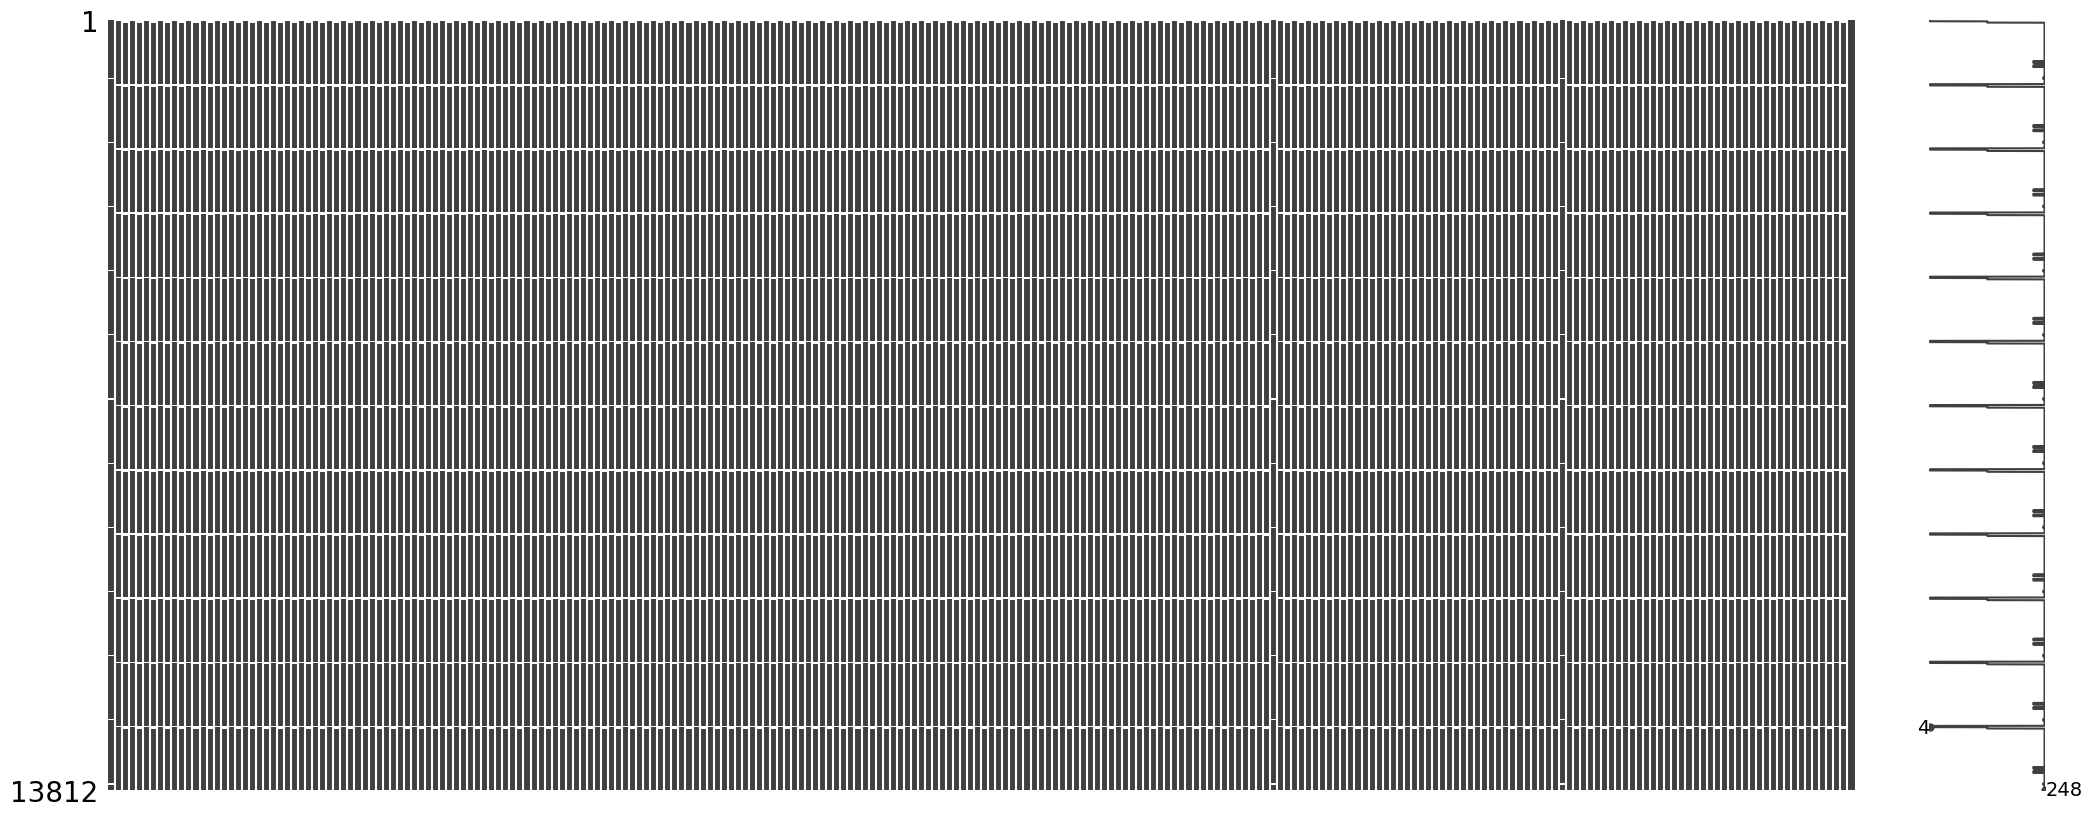

0.0 0 values missing after day 17 for all Jan-Mar


In [271]:
# Select columns from columns_minor_NA
df_subset = dfpd[columns_minor_NA + ['timestamp']]

# Filter for January-March period and days from 1 to 16
df_subset = df_subset[(df_subset['timestamp'].dt.month.isin([1, 2, 3])) &
                      (df_subset['timestamp'].dt.day >= 1) &
                      (df_subset['timestamp'].dt.day <= 16)]

# Plot missing values matrix
msno.matrix(df_subset)
plt.show()
print(sum(df_subset[df_subset['timestamp'].dt.day >= 17].isna().sum()), '0 values missing after day 17 for all Jan-Mar')

Let's check once again that interpolation goes correctly for minor cases. We take X65, hub 1, 15.02.2023, 20:00. At 19:00 it had 0.0672727272727273 and at 21:00 it had 0. Interpolated value should be 0.03.

In [272]:

print(dfpd.query('day==15 & month == 2 & hour == 19 & hub == 1')['X65'])
print(dfpd.query('day==15 & month == 2 & hour == 20 & hub == 1')['X65'])
print(dfpd.query('day==15 & month == 2 & hour == 21 & hub == 1')['X65'])


2305    0.067273
Name: X65, dtype: float64
2424   NaN
Name: X65, dtype: float64
2543    0.0
Name: X65, dtype: float64


In [273]:
# List of columns for which we will perform interpolation
slice_cols = ['timestamp', 'hub', 'hour']
slice_cols.extend(columns_minor_NA)

# Iterate over each unique hub
for hub in dfpd['hub'].unique():
    # Filter the DataFrame for the current hub
    df_hub = dfpd[dfpd['hub'] == hub]
    
    # Apply linear interpolation for every column in the current hub subset
    for column_name in slice_cols:
        if column_name not in ['timestamp', 'hub', 'hour', 'X112']:  # we don't want to interpolate these
            df_hub[column_name] = df_hub[column_name].interpolate(method='linear', limit_direction='both')
    
    # Assign the interpolated data back to the main DataFrame
    dfpd.loc[dfpd['hub'] == hub] = df_hub


C:\Users\fs335ld\AppData\Local\Temp\ipykernel_2116\3315036739.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_hub[column_name] = df_hub[column_name].interpolate(method='linear', limit_direction='both')


Interpolation was successful. We got 0.03 as expected for X65.

2424    0.033636
Name: X65, dtype: float64


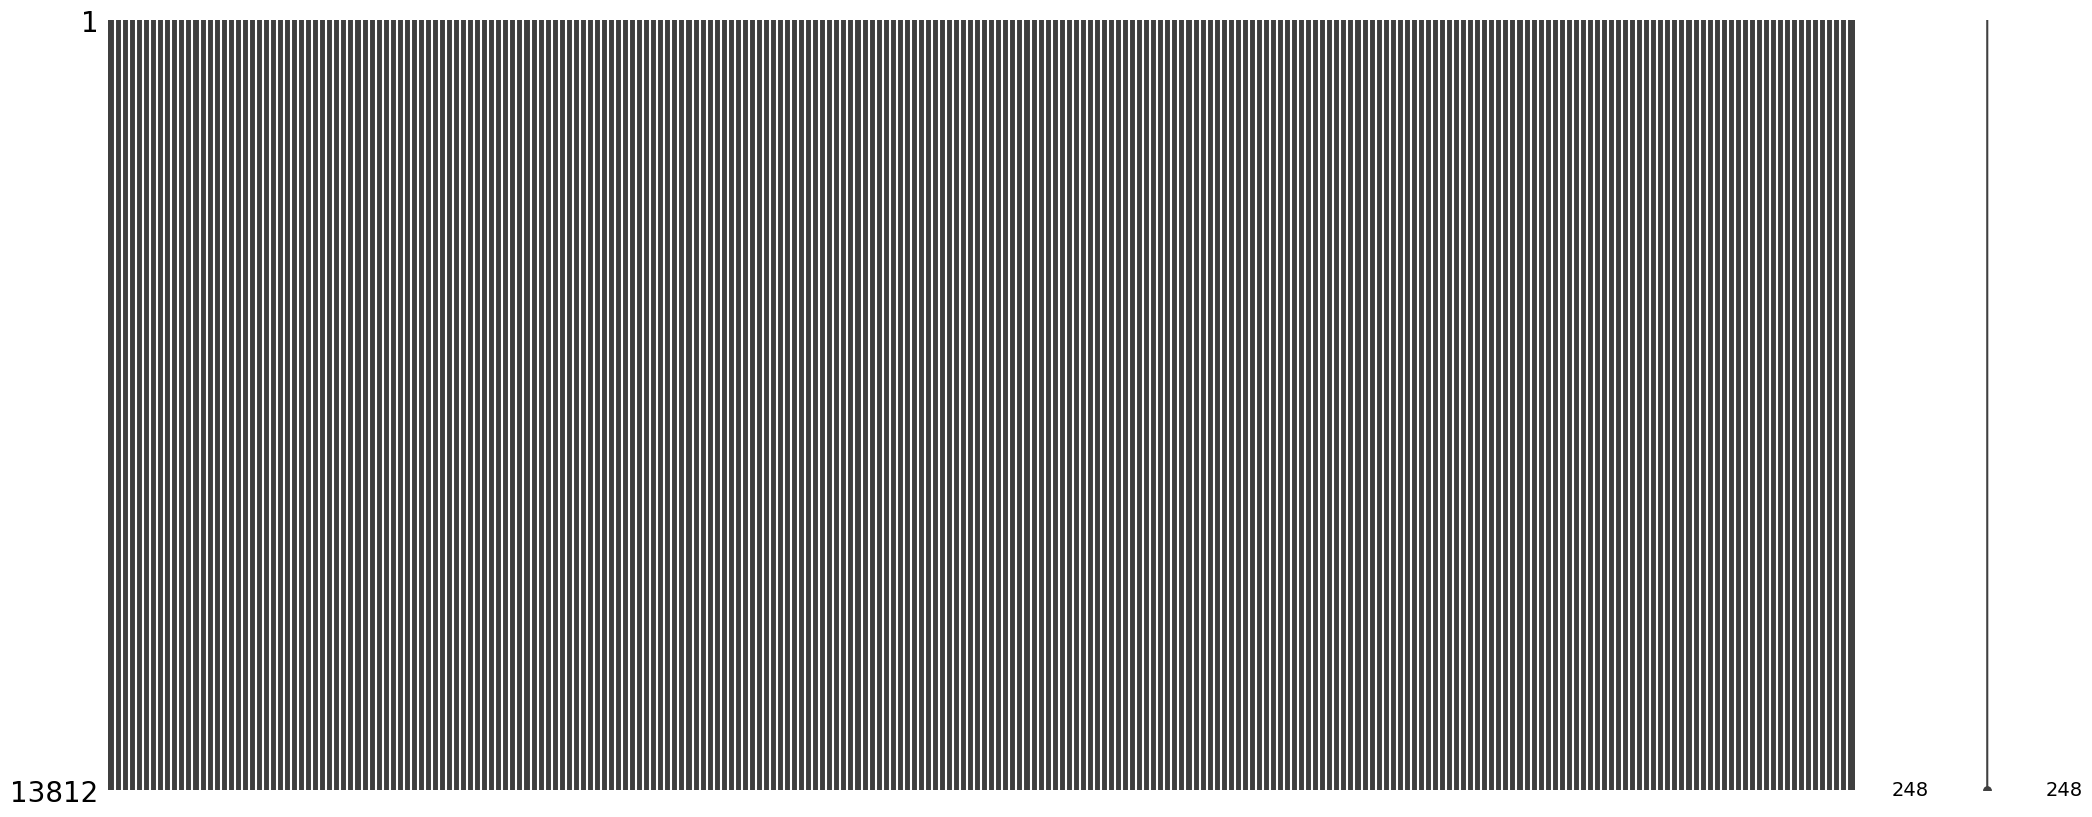



[]


In [274]:
print(dfpd.query('day==15 & month == 2 & hour == 20 & hub == 1')['X65']) 
# Select columns from columns_minor_NA
df_subset = dfpd[columns_minor_NA + ['timestamp']]

# Filter for January-March period and days from 1 to 16
df_subset = df_subset[(df_subset['timestamp'].dt.month.isin([1, 2, 3])) &
                      (df_subset['timestamp'].dt.day >= 1) &
                      (df_subset['timestamp'].dt.day <= 16)]

# Plot missing values matrix
msno.matrix(df_subset)
plt.show()

print('\n')
# Let's identify where else do we have missing values:
# Create a mask that identifies rows with any missing values in columns from columns_minor_NA
mask = df_subset[columns_minor_NA].isna().any(axis=1)

# Apply the mask to df_subset to filter rows with missing values
df_missing_values = df_subset[mask]

# Print the unique dates with missing values
print(df_missing_values['timestamp'].dt.date.unique())


In [275]:
import datetime
# Create a mask for dates excluding 1st and 2nd of January
date_mask = (dfpd['timestamp'] != datetime.date(2023, 1, 1)) & (dfpd['timestamp'] != datetime.date(2023, 1, 2))

# Apply the mask to the dataframe
filtered_df = dfpd[date_mask]

# Find columns with missing values
missing_values = filtered_df.isna().sum()
missing_values_columns = missing_values[missing_values > 0]

# Print the column names with missing values
print(missing_values_columns.index.tolist(), 'The only left missing values are in X112')


['X112'] The only left missing values are in X112


# 4. Feature Engineering
We managed to remove missing values where we expected them not to be. We did interpolation with both directions to handle the case, when there're multiple consecutive NAs, but it also filled in values for January 1 and 2. Still, it's not a problem, as we've decided already to drop these two days. At the moment, we have missing values only for X112.

Before removing first 2 days entirely from the dataset, we want to do feature engineering. As we are working with hourly energy prices, which involved autocorrelation, we will use lagged variables + moving averages, which could enhance our model predictability. There were no missing values for target variable y, so we could first get our features, and then drop first two days with missing values.

In [276]:
# checking for duplicated rows in our dataset
duplicates = dfpd.duplicated(keep='first').sum()

print('There are {} duplicate rows in dfpd based on all columns.'
      .format(duplicates))

There are 0 duplicate rows in dfpd based on all columns.


Let's generate dummy variables which would indicate whether the case is with business hours or not, as this is the time, when the highest demand for energy is. Also, additional category would indicate whether we deal with a working day or weekend.

In [277]:
# Define the business hour category based on the hour of the day
def business_hour_category(hour):
    if (hour >= 8 and hour < 18):
        return 1
    else:
        return 0

# Define the weekend category based on the day of the week
def weekend_category(weekday):
    if (weekday >= 5): # Considering both Saturday and Sunday as weekend
        return 1
    else:
        return 0

# Generate 'business hour' and 'weekend' features
dfpd['business hour'] = dfpd['timestamp'].dt.hour.apply(business_hour_category)
dfpd['weekend'] = dfpd['timestamp'].dt.weekday.apply(weekend_category)


The instructions of the task are: You can use data (fit set) until 10:59 am from the previous day for the predictions. For example, if you predict the hourly prices for the 1st of April, you can use data (fit set) from the 1st of January to 10:59 am on the 31st of March, 2023; or if you predict prices for the 2nd of April, you can use data (fit set) until 10:59 until the 1st of April, 2023.

We need to fulfill this information and adjust our X predictors. However, information about energy prices should be available immediately, so we can engineer features out of y without constraining ourselves with the data availability and without any data leakage. Also, as we proved with correlograms, prices tend to be highly autocorrelated and have daily seasonalities, which allows us to use multiple lags. For that reason, we will create the following features:

a. Lagged y by 1, 2, 3, 23 and 24 hours based on correlograms.

b. t-1 simple moving average with periods of 10, 24 and 47 hours. 47 here is to stay within 2-day-period which we intend to drop.

c. Next, we will work with X variables. For columns_minor_NA and other variables which had no missing values we will use the following trick: for the period of 00:00 till 10:59, we will use 24h lag. For the period of 11:00 till 23:00, we will use 48h lag. The biggest information gap happens at 23:00 day t compared to day t-1, which is 37 hours. So, by doing 48h lag, we are fulfilling the requirement but also keeping the necessary information available as very probably there's still some lagged relationship with target and predictors.

d. For columns_extreme_NA from 11:00 till 23:00 we had missing values filled in with the average of the day -> which means that there's no data leakage, as information about 00:00 till 10:59 of t-1 is available at the time of prediction of t. We will simply lag these variables by 24 hours.

e. At the end we will drop first two days of January, as we intended to do before.


In [278]:
# a. Shift y values to create lagged features
for lag in [1, 2, 3, 23, 24]:
    dfpd[f'y_{lag}'] = dfpd['y'].shift(periods=lag)


In [279]:
# b. t-1 simple moving average with periods of 9, 23 and 47 hours
for period in [10, 24, 47]:
    dfpd[f'y_1_sma_{period}'] = dfpd.groupby('hub')['y_1'].transform(lambda x: x.rolling(period).mean())


In [280]:
# c. Create a column indicating whether the time is before or after 11:00
dfpd['is_morning'] = dfpd['hour'] < 11
dfpd.drop('X', axis=1, inplace=True)
# Identify columns starting with 'X' that are not in 'columns_extreme_NA' or 'columns_minor_NA'
all_columns = set(dfpd.filter(regex='^X').columns)
missing_columns = all_columns - set(columns_extreme_NA) - set(columns_minor_NA)

# Include columns from columns_minor_NA, missing columns, and 'X112'
temporary_list = list(columns_minor_NA) + list(missing_columns) + ['X112']

# Create new DataFrames to hold the lagged columns and the final lagged version
lagged_24h_df = pd.DataFrame()
lagged_48h_df = pd.DataFrame()

# For each column in temporary_list, create the 24h and 48h lagged versions
for col in temporary_list:
    lagged_24h_df[f'{col}_24h_lag'] = dfpd.groupby('hub')[col].transform(lambda x: x.shift(24))
    lagged_48h_df[f'{col}_48h_lag'] = dfpd.groupby('hub')[col].transform(lambda x: x.shift(48))

# Concatenate the new DataFrames with the original one
dfpd = pd.concat([dfpd, lagged_24h_df, lagged_48h_df], axis=1)

# Create a new set of columns that would either take the value from the 24h lagged or 48h lagged columns based on the 'is_morning' flag
for col in temporary_list:
    dfpd[f'{col}_lagged'] = np.where(dfpd['is_morning'], dfpd[f'{col}_24h_lag'], dfpd[f'{col}_48h_lag'])

# Drop the original columns from temporary_list as well as the intermediate 24h and 48h lagged columns
dfpd.drop(temporary_list, axis=1, inplace=True)
dfpd.drop([f'{col}_24h_lag' for col in temporary_list], axis=1, inplace=True)
dfpd.drop([f'{col}_48h_lag' for col in temporary_list], axis=1, inplace=True)


C:\Users\fs335ld\AppData\Local\Temp\ipykernel_2116\3125963166.py:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  lagged_24h_df[f'{col}_24h_lag'] = dfpd.groupby('hub')[col].transform(lambda x: x.shift(24))
C:\Users\fs335ld\AppData\Local\Temp\ipykernel_2116\3125963166.py:18: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  lagged_48h_df[f'{col}_48h_lag'] = dfpd.groupby('hub')[col].transform(lambda x: x.shift(48))
C:\Users\fs335ld\AppData\Local\Temp\ipykernel_2116\3125963166.py:17: PerformanceWarning: DataFrame is highly fragmented.

In [281]:
# d. Create lagged versions of the extreme NA columns
temporary_list = list(columns_extreme_NA)
temporary_list.remove('X112')

# Create a new DataFrame to hold the lagged columns
lagged_df = pd.DataFrame()

for col in temporary_list:
    lagged_df[f'{col}_lag_24'] = dfpd.groupby('hub')[col].shift(24)

# Concatenate the new DataFrame with the original one
dfpd = pd.concat([dfpd, lagged_df], axis=1)

# Drop the initial columns
dfpd = dfpd.drop(columns=temporary_list)


In [282]:
# e. Dropping first 2 days of the datset
# Set the timestamp as index
dfpd.set_index('timestamp', inplace=True)

# Drop the first two days
dfpd = dfpd[dfpd.index > '2023-01-02 23:59:59']


# 5. Predictive Modeling
In this section, we'll tackle the task of forecasting prices. Our dataset will be divided into 12 separate hubs, each one represented by a distinct model. These models will be trained on data from the first 10 weeks, followed by validation and hyperparameter tuning using the remaining weeks. The ultimate goal is to predict hourly prices for April.

We'll employ an expanding learning window approach, allowing the training set to increase progressively, and eventually incorporating data from April into the validation set. Given the small size of our dataset and the presence of 12 distinct hubs, we'll steer clear of advanced ML and Deep Learning algorithms, such as XGBoost or Long Short-Term Memory (LSTM) networks. Instead, we'll harness the power of the Random Forest algorithm. This algorithm is less demanding in terms of parameter tuning, yet it remains effective with smaller dataset sizes.

To reduce the noise from our X predictors and enhance our flexibility, we'll implement Principal Component Analysis (PCA). This method should allow us to effectively summarize our predictors if the relationship among variables is linear. The traditional time-series cross-validation approach, which splits data into k folds (using k-1 for training and 1 for validation), doesn't necessarily apply to our case. This approach functions similarly to our expanding window strategy, for instance, using January for training, followed by two weeks of February for validation, and so on. Given our limited data and considering the temporal proximity of March to April, it makes more sense to use the weeks in March directly for validation.

Our pipeline will be structured as follows: Firstly, the dataset will be divided into training, validation, and testing sets. Then, PCA will be applied to the X1-X798 from the training set to extract n components that account for at least 90% of the variability in X predictors. As PCA requires numbers to be in similar scales, we will standardize our X variables. This will be followed by model training and tuning on the validation set. After that, the model is retrained with the validation set and makes predictions for the first day's hourly prices in the testing set. This day is then added to the training set, and the model is retrained with the same hyperparameters to predict prices for the following day. Predictions will be recorded in separate dataframes. Once we've predicted the first week of April, hyperparameters are tuned again using the validation set, and we start predicting for the next week. This process continues until we've exhausted the testing set.

Before starting this process, we'll also include dummy variables for datetime-related variables such as hour, month, and day of the week. This will ensure that the algorithm recognizes these as categorical variables.

In [291]:
df_final = dfpd.copy() # Let's make a copy in case we mess up with the dataset

In [292]:
# Drop unneccesary columns and add dummies
df_final = df_final.drop(['day', 'is_morning'], axis=1)
# Add dummies for 'hour'
hour_dummies = pd.get_dummies(df_final['hour'], prefix='hour', drop_first=True)
hour_dummies.index = df_final.index

# Add dummies for 'month'
month_dummies = pd.get_dummies(df_final['month'], prefix='month', drop_first=True)
month_dummies.index = df_final.index

# Add dummies for 'day_of_week'
day_of_week_dummies = pd.get_dummies(df_final['day_of_week'], prefix='day_of_week', drop_first=True)
day_of_week_dummies.index = df_final.index

# Concatenate original dataframe with dummy variables
df_final = pd.concat([df_final, hour_dummies, month_dummies, day_of_week_dummies], axis=1)

df_final = df_final.drop(['hour', 'month', 'day_of_week'], axis=1)

Code below does the following steps:


1. Segregates the main dataset by each 'hub' into separate dataframes.

2. Defines predictor columns by selecting those starting with 'X'.

3. Establishes train/validation/test split dates, and the dates for hyperparameter tuning.

4. Processes data for each 'hub', including:

- The train, validation, and test split
- The initialization of the scaler, PCA, and random forest regressor
- The scaling and PCA transformation of the training X.

5. Utilizes a defined function to preprocess the validation data.

6. Executes hyperparameter tuning for the RandomForest models, utilizing a grid search approach.

7. Combines the training and validation datasets for final model training and then preprocesses the combined dataset.

8. Sets the optimized hyperparameters and fits the RandomForest model on the combined dataset.

9. Implements a daily prediction loop for the test dataset that includes preprocessing the daily data, making predictions, and updating the training dataset with each day's data.

10. Retrains the model with the updated dataset.

11. Performs hyperparameter tuning at specified dates (each new week of April), using the data from the past 21 days as a rolling validation set.

12. Saves the predictions for each hub in separate CSV files.

In [287]:
# Define the data preprocess function
def preprocess_data(df, scaler, pca, columns):
    """Preprocess the data: scaling and PCA transformation."""
    X = scaler.transform(df[columns])
    X_pca = pca.transform(X)
    df_transformed = pd.DataFrame(X_pca, index=df.index, columns=[f'PC{i}' for i in range(1, X_pca.shape[1] + 1)])
    other_cols = [col for col in df.columns if col not in columns]
    df_transformed = pd.concat([df_transformed, df[other_cols]], axis=1)
    return df_transformed

# Define the function to tune hyperparameters
def tune_hyperparameters(rf, train, validation):
    # Define the grid for hyperparameter tuning
    grid = {'n_estimators': [50, 100, 500, 1000],
        'max_depth': [5, 10, 20],
        'max_features': ['sqrt','log2'],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [2, 4],
        'bootstrap': [False]} # usually not a good approach to use bootstrapping with time series

    min_mse = np.inf
    best_params = None
    for g in ParameterGrid(grid): # deterministically tries all the combinations. No need to define seed.
        rf.set_params(**g)
        rf.fit(train.drop('y', axis=1), train['y'])
        predictions = rf.predict(validation.drop('y', axis=1))
        mse = mean_squared_error(validation['y'], predictions)
        if mse < min_mse:
            min_mse = mse
            best_params = g
    return best_params

In [288]:
# Split dataset into separate hubs
hub_dfs = {hub: df_final[df_final['hub'] == hub] for hub in df_final['hub'].unique()} # keys are hubs (1,2 etc.), values are datasets

# Define train/validation/test split dates
train_end_date = '2023-03-12'  # end of 10th week
validation_end_date = '2023-03-31 23:59:59'   # Everything before April.

# Define dates for hyperparameter tuning
tuning_dates = ['2023-04-08', '2023-04-15', '2023-04-22'] # once in a week
X112_hubs = [1,7,11]

# Initialize all_predictions dataframe, where all predictions for all hubs will be saved
all_predictions = pd.DataFrame()
# Process data for each hub
for hub, df in hub_dfs.items():
    df.sort_index(inplace=True)
    if hub not in X112_hubs:
        df.drop('X112_lagged',axis=1,inplace=True)
    
    # Extract predictors starting with 'X'
    x_cols = [col for col in df.columns if col.startswith('X')] # should be recreated each time due to X112
    
    # Split into train, validation and test
    train = df[df.index <= train_end_date]
    validation = df[(df.index > train_end_date) & (df.index <= validation_end_date)]
    test = df[df.index > validation_end_date]

    # Initialize the scaler, PCA, and random forest regressor. Each hub has its own initialization
    scaler = StandardScaler()
    pca = PCA(n_components=0.90)  # 90% variance. Chosen arbitrarily
    rf = RandomForestRegressor(random_state=2023)

    # Preprocess the data
    X_train = scaler.fit_transform(train[x_cols])
    pca.fit(X_train)
    train_transformed = preprocess_data(train, scaler, pca, x_cols)

    # Process validation data
    validation_transformed = preprocess_data(validation, scaler, pca, x_cols)

    # Tune hyperparameters
    best_params = tune_hyperparameters(rf, train_transformed, validation_transformed)
    print(f"Best parameters for hub {hub}: {best_params}")

    # Concatenate train and validation for final model training
    train_val = pd.concat([train, validation])
    train_val_transformed = preprocess_data(train_val, scaler, pca, x_cols)

    rf.set_params(**best_params)
    rf.fit(train_val_transformed.drop('y', axis=1), train_val_transformed['y'])

    # Prediction loop for each day in the test set
    start_date = test.index.min().date()
    end_date = test.index.max().date()
    delta = datetime.timedelta(days=1)
    current_date = start_date
    
    # Initializing predictions dataframe
    predictions = pd.DataFrame()

    while current_date <= end_date:
        # Extract data for the current day
        current_day = test[test.index.date == current_date]

        # Preprocess current day data
        current_day_transformed = preprocess_data(current_day, scaler, pca, x_cols)

        # Make and save predictions for the current day
        pred = rf.predict(current_day_transformed.drop('y', axis=1))
        pred_df = pd.DataFrame(pred, index=current_day.index, columns=['y_pred'])
        predictions = pd.concat([predictions, pred_df])

        # Add the current day to the training set
        train_val = pd.concat([train_val, current_day])

        # Re-preprocess the data
        train_val_transformed = preprocess_data(train_val, scaler, pca, x_cols)

        # Retrain the model with the updated training set
        rf.fit(train_val_transformed.drop('y', axis=1), train_val_transformed['y'])

        # Hyperparameter tuning on specific dates
        if current_date.strftime('%Y-%m-%d') in tuning_dates:
            # Use the last 21 days as a rolling validation set
            rolling_val = train_val[-21*24:]
            # Exclude the rolling validation data from the training set
            train_tune = train_val[:-21*24]
            # Refit the scaler and PCA
            X_train_tune = scaler.fit_transform(train_tune[x_cols])

            rolling_val_transformed = preprocess_data(rolling_val, scaler, pca, x_cols)
            train_tune_transformed = preprocess_data(train_tune, scaler, pca, x_cols)
            best_params = tune_hyperparameters(rf, train_tune_transformed, rolling_val_transformed)
            rf.set_params(**best_params)
            rf.fit(train_val_transformed.drop('y', axis=1), train_val_transformed['y'])
            print(f"Hyperparameters tuned on {current_date}")

        # Update the current date
        current_date += delta

    print(f"Predictions for hub {hub} have been made and model retrained with all available data up to {current_date-delta}")

    predictions.to_csv(f"hub_{hub}_predictions.csv")
    
    predictions['hub'] = hub
    predictions = pd.DataFrame(predictions, columns=['y_pred', 'hub'], index=test.index)

    all_predictions = pd.concat([all_predictions, predictions])  # Add predictions directly to all_predictions with correct hub
all_predictions.to_csv("all_predictions.csv")

Best parameters for hub 1: {'bootstrap': False, 'max_depth': 20, 'max_features': 'sqrt', 'min_samples_leaf': 4, 'min_samples_split': 10, 'n_estimators': 100}
Hyperparameters tuned on 2023-04-08
Hyperparameters tuned on 2023-04-15
Hyperparameters tuned on 2023-04-22
Predictions for hub 1 have been made and model retrained with all available data up to 2023-04-29


C:\Users\fs335ld\AppData\Local\Temp\ipykernel_2116\3757461653.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.drop('X112_lagged',axis=1,inplace=True)


Best parameters for hub 2: {'bootstrap': False, 'max_depth': 20, 'max_features': 'sqrt', 'min_samples_leaf': 4, 'min_samples_split': 2, 'n_estimators': 100}
Hyperparameters tuned on 2023-04-08
Hyperparameters tuned on 2023-04-15
Hyperparameters tuned on 2023-04-22
Predictions for hub 2 have been made and model retrained with all available data up to 2023-04-29


C:\Users\fs335ld\AppData\Local\Temp\ipykernel_2116\3757461653.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.drop('X112_lagged',axis=1,inplace=True)


Best parameters for hub 3: {'bootstrap': False, 'max_depth': 20, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 100}
Hyperparameters tuned on 2023-04-08
Hyperparameters tuned on 2023-04-15
Hyperparameters tuned on 2023-04-22
Predictions for hub 3 have been made and model retrained with all available data up to 2023-04-29


C:\Users\fs335ld\AppData\Local\Temp\ipykernel_2116\3757461653.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.drop('X112_lagged',axis=1,inplace=True)


Best parameters for hub 4: {'bootstrap': False, 'max_depth': 20, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 100}
Hyperparameters tuned on 2023-04-08
Hyperparameters tuned on 2023-04-15
Hyperparameters tuned on 2023-04-22
Predictions for hub 4 have been made and model retrained with all available data up to 2023-04-29


C:\Users\fs335ld\AppData\Local\Temp\ipykernel_2116\3757461653.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.drop('X112_lagged',axis=1,inplace=True)


Best parameters for hub 5: {'bootstrap': False, 'max_depth': 20, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 100}
Hyperparameters tuned on 2023-04-08
Hyperparameters tuned on 2023-04-15
Hyperparameters tuned on 2023-04-22
Predictions for hub 5 have been made and model retrained with all available data up to 2023-04-29


C:\Users\fs335ld\AppData\Local\Temp\ipykernel_2116\3757461653.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.drop('X112_lagged',axis=1,inplace=True)


Best parameters for hub 6: {'bootstrap': False, 'max_depth': 20, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 100}
Hyperparameters tuned on 2023-04-08
Hyperparameters tuned on 2023-04-15
Hyperparameters tuned on 2023-04-22
Predictions for hub 6 have been made and model retrained with all available data up to 2023-04-29
Best parameters for hub 7: {'bootstrap': False, 'max_depth': 20, 'max_features': 'sqrt', 'min_samples_leaf': 4, 'min_samples_split': 2, 'n_estimators': 50}
Hyperparameters tuned on 2023-04-08
Hyperparameters tuned on 2023-04-15
Hyperparameters tuned on 2023-04-22
Predictions for hub 7 have been made and model retrained with all available data up to 2023-04-29


C:\Users\fs335ld\AppData\Local\Temp\ipykernel_2116\3757461653.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.drop('X112_lagged',axis=1,inplace=True)


Best parameters for hub 8: {'bootstrap': False, 'max_depth': 10, 'max_features': 'sqrt', 'min_samples_leaf': 4, 'min_samples_split': 2, 'n_estimators': 100}
Hyperparameters tuned on 2023-04-08
Hyperparameters tuned on 2023-04-15
Hyperparameters tuned on 2023-04-22
Predictions for hub 8 have been made and model retrained with all available data up to 2023-04-29


C:\Users\fs335ld\AppData\Local\Temp\ipykernel_2116\3757461653.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.drop('X112_lagged',axis=1,inplace=True)


Best parameters for hub 9: {'bootstrap': False, 'max_depth': 20, 'max_features': 'sqrt', 'min_samples_leaf': 4, 'min_samples_split': 10, 'n_estimators': 100}
Hyperparameters tuned on 2023-04-08
Hyperparameters tuned on 2023-04-15
Hyperparameters tuned on 2023-04-22
Predictions for hub 9 have been made and model retrained with all available data up to 2023-04-29


C:\Users\fs335ld\AppData\Local\Temp\ipykernel_2116\3757461653.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.drop('X112_lagged',axis=1,inplace=True)


Best parameters for hub 10: {'bootstrap': False, 'max_depth': 20, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 100}
Hyperparameters tuned on 2023-04-08
Hyperparameters tuned on 2023-04-15
Hyperparameters tuned on 2023-04-22
Predictions for hub 10 have been made and model retrained with all available data up to 2023-04-29
Best parameters for hub 11: {'bootstrap': False, 'max_depth': 20, 'max_features': 'sqrt', 'min_samples_leaf': 4, 'min_samples_split': 10, 'n_estimators': 500}
Hyperparameters tuned on 2023-04-08
Hyperparameters tuned on 2023-04-15
Hyperparameters tuned on 2023-04-22
Predictions for hub 11 have been made and model retrained with all available data up to 2023-04-29


C:\Users\fs335ld\AppData\Local\Temp\ipykernel_2116\3757461653.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.drop('X112_lagged',axis=1,inplace=True)


Best parameters for hub 12: {'bootstrap': False, 'max_depth': 20, 'max_features': 'sqrt', 'min_samples_leaf': 4, 'min_samples_split': 2, 'n_estimators': 500}
Hyperparameters tuned on 2023-04-08
Hyperparameters tuned on 2023-04-15
Hyperparameters tuned on 2023-04-22
Predictions for hub 12 have been made and model retrained with all available data up to 2023-04-29


This final step uses RMSE to compare real y values with predicted y 

In [289]:
# Reset the index on all_predictions so that 'timestamp' becomes a regular column
all_predictions_reset = all_predictions.reset_index()

# Reset index on df_final
df_final_reset = df_final.reset_index()

# Merge on both 'timestamp' and 'hub'
df_combined = pd.merge(all_predictions_reset, df_final_reset[['timestamp', 'y', 'hub']], 
                       on=['timestamp', 'hub'], how='inner')

# Calculate RMSE
rmse = mean_squared_error(df_combined['y_pred'], df_combined['y'], squared=False)
print("RMSE for all the hubs together is: ", rmse)
print('\n')
# Calculate RMSE for each hub
rmse_per_hub = df_combined.groupby('hub').apply(lambda group: mean_squared_error(group['y_pred'], group['y'],squared=False))

print("RMSE per hub: ", rmse_per_hub)

RMSE for all the hubs together is:  11.722474269362351


RMSE per hub:  hub
1      9.996626
2      9.874653
3      9.714780
4     15.299244
5     15.162126
6     14.893370
7      7.687245
8      7.049491
9     15.082730
10     9.952782
11    10.460655
12    11.253808
dtype: float64
